# Выполнено Зверьковой Елизаветой Алексеевной

# Сессия 3

## В третьей сессии нам предстоит проделать следующую работу:
- найти зависимости в данных 
- кластеризировать текст обращения граждан

In [3]:
#импорты
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
import re

In [4]:
df = pd.read_csv('df.csv', index_col=0) #сохраненный ранее датасет

In [5]:
df = df.fillna('') #заполним пропуски в данных для дальнейшей работы

In [5]:
df

date                                      petition_text  \
0      2020-11-13                                            коридор   
1      2020-11-05                             лифт изрисовать внутри   
2      2020-11-03                                   реклама светофор   
3      2020-11-23                      квартирный холл рааботник тсж   
4      2020-12-16                           незаконный решётка фасад   
...           ...                                                ...   
59884  2021-04-23  систематический блокирование парковка крупнога...   
59885  2021-04-23  маршал захаров высокий точка младший школа мал...   
59886  2021-04-23  люк выдавить гранитный мощение люк выдавить пл...   
59887  2021-04-23                             поврежда н асфальт люк   
59888  2021-04-23  кадастровый карта дать участок дорога принадле...   

                                         reason_petition  \
0                неудовлетворительное состояние парадной   
1                неудовлетворительное состояние парадной   
2      несанкционированные надписи   объявления на те...   
3                неудовлетворительное состояние парадной   
4      самовольное размещение наружн  блоков систем к...   
...                                                  ...   
59884                 мусор на внутридворовой территории   
59885                                   неочищенные урны   
59886       неудовлетворительное состояние колодца  люка   
59887       неудовлетворительное состояние колодца  люка   
59888     повреждения дорожного покрытия  проезжей части   

                                       category_petition  \
0                                         Содержание МКД   
1                                         Содержание МКД   
2                                        Благоустройство   
3                                         Содержание МКД   
4          Нарушение правил пользования общим имуществом   
...                                                  ...   
59884                                    Благоустройство   
59885                                    Благоустройство   
59886  Повреждения или неисправность элементов улично...   
59887  Повреждения или неисправность элементов улично...   
59888                                    Благоустройство   

                                               key_words  
0                                                коридор  
1            внутри, изрисовать, изрисовать внутри, лифт  
2                    реклама, реклама светофор, светофор  
3      квартирный, квартирный холл, квартирный холл р...  
4      незаконный, незаконный решётка, незаконный реш...  
...                                                  ...  
59884  блокирование, блокирование парковка, блокирова...  
59885           разбитый, разбитый сломаный, урна, школа  
59886                      выдавить, люк, мощение, плита  
59887                асфальт, асфальт люк, люк, поврежда  
59888    дорога, кадастровый, кадастровый карта, участок  

[59835 rows x 5 columns]

# Перегруппировка данных

Сейчас нам необходимо перегруппировать данные для более удобной работы над последующими действиями

Колонку с датой полной датой обращения заменим месяцем обращения, так как, во-первых, именно таким образом график зависимостей будет наиболее наглядным. Во-вторых, зная месяц обращения, легче проанализировать зависимость и взаимосвязь между категорией обращения и, соответственно, месяцем

In [6]:
#создаем отдельную колонку с месяцем
df['month'] = pd.DatetimeIndex(df['date']).month

#дропаем колонку с полной датой, так как далее она нам не понадобится
df = df.drop('date', axis=1)

#месяца представлены в виде чисел, поэтому с помощью функции map заменим их на сами названия месяцев, это упростит дальнейшую работу
months = {1:'январь', 2:'февраль', 3:'март', 4:'апрель', 5:'май', 6:'июнь', 7:'июль', 8:'август', 9:'сентябрь', 10:'октябрь', 11:'ноябрь', 12:'декабрь'}
df["month"] = df["month"].map(months)

Для начала добавляем пробелы после каждой строки, чтобы при перегруппировке предложения не сливались в одно слово 

In [7]:
df['month'] = df['month'].apply(lambda x: x + ' ') 
df['petition_text'] = df['petition_text'].apply(lambda x: str(x) + ' ')
df['reason_petition'] = df['reason_petition'].apply(lambda x: x + ' ')
df['key_words'] = df['key_words'].apply(lambda x: str(x) + ' ')

Перегруппируем данные с помощью метода `groupby` исходя из нашей целевой переменной `категория обращения` ('category_petition'), создав новый датафрейм `n_df`

In [8]:
n_df = df.groupby(['category_petition'])['reason_petition', 'key_words', 'month', 'petition_text'].agg('sum').reset_index()

Мы видим, что вышло всего 15 категорий обращений, и по каждой категории были суммированы все данные ее касающиеся

In [9]:
n_df

category_petition  \
0                                     Благоустройство   
1                                       Водоотведение   
2                                       Водоснабжение   
3                                              Кровля   
4      Нарушение порядка пользования общим имуществом   
5       Нарушение правил пользования общим имуществом   
6   Незаконная информационная и (или) рекламная ко...   
7   Незаконная реализация товаров с торгового обор...   
8   Повреждения или неисправность элементов улично...   
9                                             Подвалы   
10                               Санитарное состояние   
11                                     Содержание МКД   
12  Состояние рекламных или информационных констру...   
13                                              Фасад   
14                              Центральное отопление   

                                      reason_petition  \
0   несанкционированные надписи   объявления на те...   
1   засор канализации протечка канализационной тру...   
2   плохое качество горячей воды протечка труб в п...   
3   повреждение кровли повреждение кровли поврежде...   
4   передача общего имущества собственников помеще...   
5   самовольное размещение наружн  блоков систем к...   
6   незаконное размещение информационной и  или  р...   
7   реализация товаров в местах  не предназначенны...   
8   неудовлетворительное состояние колодца  люка н...   
9   открыты закрыты подвальные окна  продухи  вход...   
10  требуется дезинсекция  насекомые   дезинфекция...   
11  неудовлетворительное состояние парадной неудов...   
12  механическое повреждение отдельно стоящей рекл...   
13  неудовлетворительное состояние окраски фасада ...   
14  низкая температура на лестничной площадке повр...   

                                            key_words  \
0   реклама, реклама светофор, светофор ограждение...   
1   канализация, парадный, подвал, подвал парадный...   
2   ночной температура, ночной температура вода, о...   
3   кровля, окрытие, парапетный, парапетный окрыти...   
4   собственность, согласие, согласие собственник,...   
5   незаконный, незаконный решётка, незаконный реш...   
6   конструкция, нелегальный, нелегальный рекламны...   
7   нелегальный, нелегальный торговля, торговля то...   
8   возле, возле люк, люк, неудовлетворительный лю...   
9   дом, многоквартирный, многоквартирный дом, про...   
10  принять, принять мера, принять мера лестница, ...   
11  коридор внутри, изрисовать, изрисовать внутри,...   
12  реклама, реклама стенд, стенд реклама, реклама...   
13  строительный, строительный отделочный, строите...   
14  низкий, низкий температура, низкий температура...   

                                                month  \
0   ноябрь ноябрь ноябрь декабрь ноябрь октябрь но...   
1   ноябрь декабрь декабрь ноябрь февраль октябрь ...   
2   ноябрь декабрь ноябрь октябрь декабрь октябрь ...   
3   январь октябрь ноябрь октябрь ноябрь март янва...   
4   декабрь октябрь ноябрь октябрь ноябрь декабрь ...   
5   декабрь декабрь декабрь декабрь декабрь декабр...   
6   январь ноябрь октябрь ноябрь февраль февраль н...   
7   декабрь декабрь февраль январь декабрь ноябрь ...   
8   декабрь октябрь октябрь октябрь ноябрь ноябрь ...   
9   ноябрь октябрь ноябрь ноябрь ноябрь октябрь де...   
10  ноябрь октябрь ноябрь ноябрь октябрь декабрь н...   
11  ноябрь ноябрь ноябрь ноябрь декабрь октябрь ок...   
12  ноябрь октябрь ноябрь ноябрь ноябрь ноябрь ноя...   
13  декабрь декабрь ноябрь ноябрь ноябрь ноябрь ок...   
14  октябрь декабрь ноябрь ноябрь ноябрь ноябрь но...   

                                        petition_text  
0   реклама светофор управлять компания самовольно...  
1   синявинский парадный засор канализация неделя ...  
2   некачественно оказываться услуга горячее водос...  
3   повреждение кровля элемент кровля вид парапетн...  
4   незаконный использование общедомовой собственн...  
5   незаконный решётка фасад самовольно установи

---

# 3.1. Визуализация зависимостей

## На этапе визуализации зависимостей нам необходимо провизуализировать:
- категории обращения и ключевые слова
- категории обращения и даты(месяца) обращения
- категории обращения и текста обращения


##### Визуализировать будем используя:
1) Bar Plot


Bar Plot (гистограмма) — это график, который представляет категориальные данные в виде прямоугольных столбцов с длиной, пропорциональной значениям, которые они представляют. Гистограмма показывает сравнение дискретных категорий. Одна ось графика показывает конкретные сравниваемые категории, а другая ось представляет измеренное значение


2) WordCloud


WordCloud (Облако слов/облако тегов) — это визуальное представление слов текстового корпуса, где визуальный размер слова пропорционален частоте или важности слова

## 1) Зависимость целевой переменной от ключевых слов

### 1.1 Bar Plot

In [13]:
#векторизируем текст для нахождения частоты вхождений слов
cv = CountVectorizer(ngram_range=(1,3), max_features=100)
cvA = cv.fit_transform(n_df["key_words"]).toarray()

#создаем датафрейм, который будет содержать частоту ключевых слов, биграмм, тиграмм и целевую переменную
cvDF = pd.DataFrame(cvA, columns=cv.get_feature_names())
cvDF["category_petition"] = n_df["category_petition"]

Создадим функцию, котрая подсчитывает ключевые слова

In [14]:
def plott(tar):
    # данные для одного графика по oX
    x=[]    
    # данные для одного графика по oY
    y=[]
    MO = cvDF[cvDF["category_petition"] == tar].drop("category_petition",axis=1) 
    for i in range(MO.shape[0]): 
        for j in cvDF.drop("category_petition",axis=1): 
            if MO.iloc[i][j]>3: 
                x.append(j)
                y.append(MO.iloc[i][j])
    return x,y

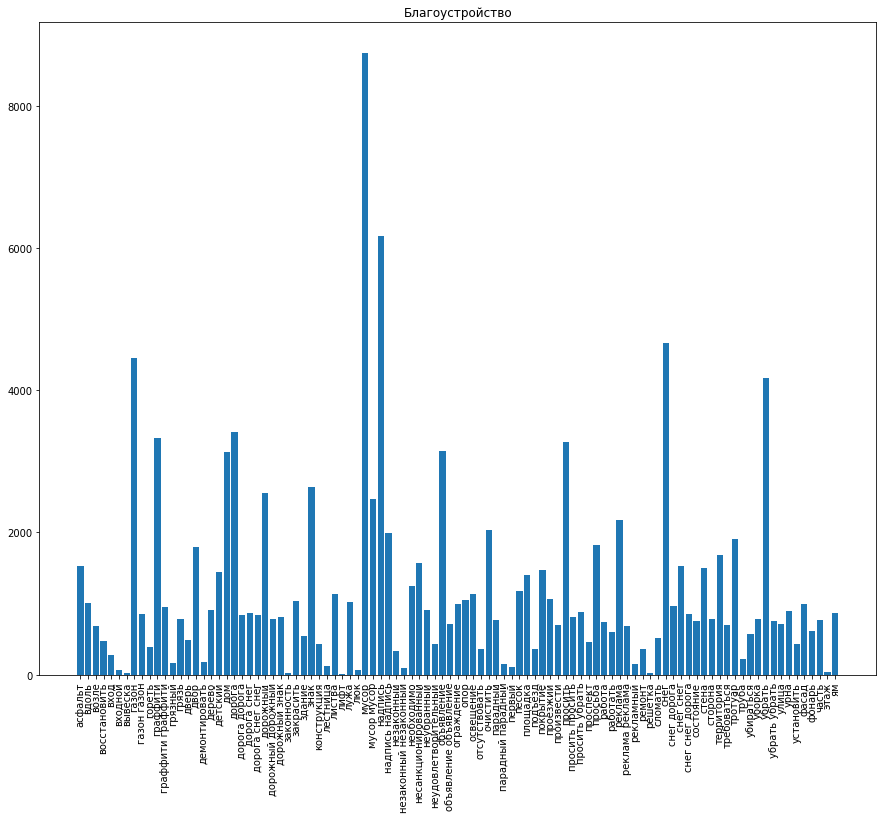

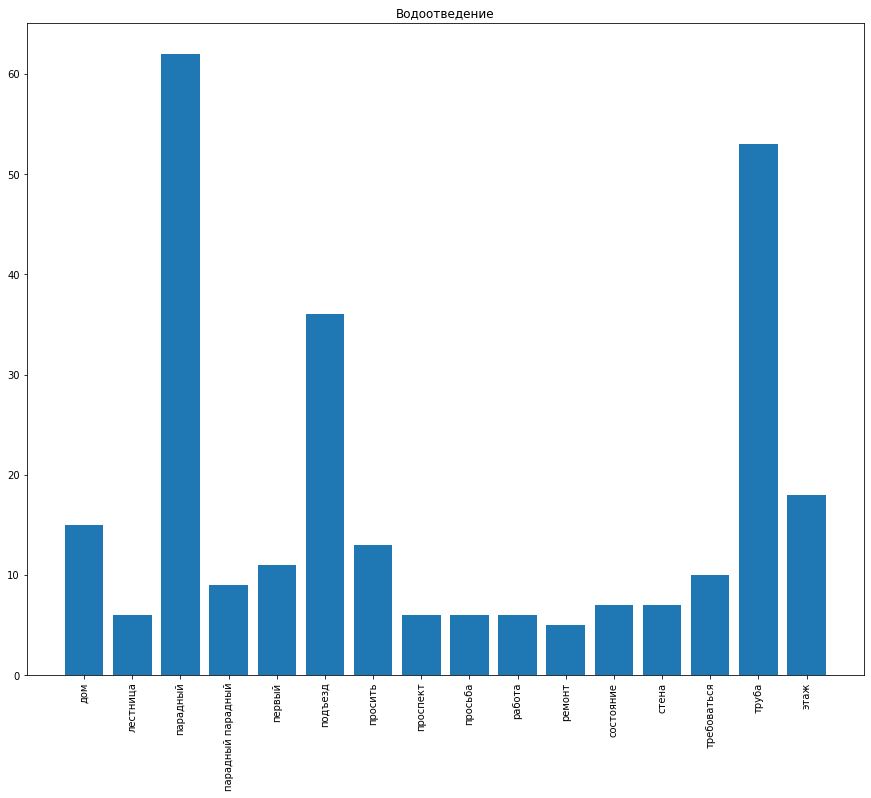

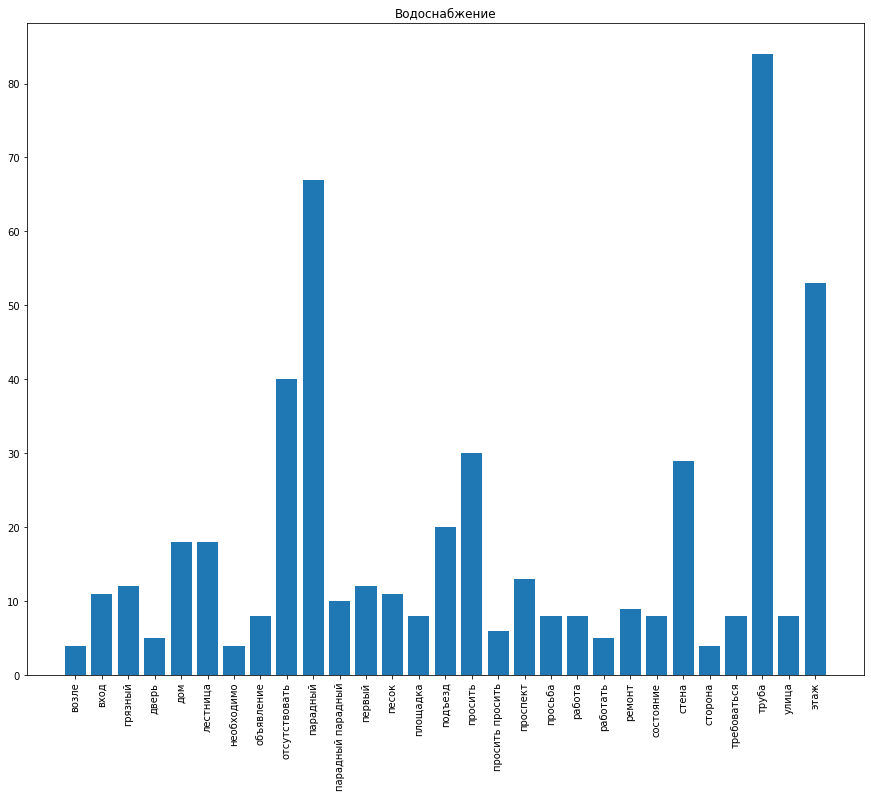

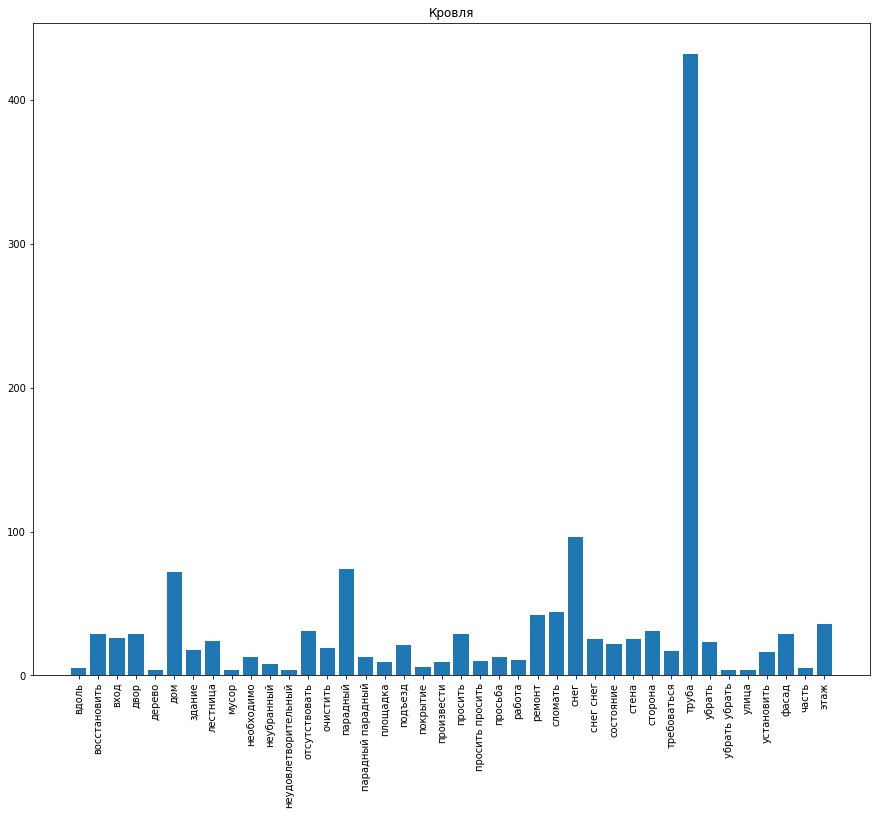

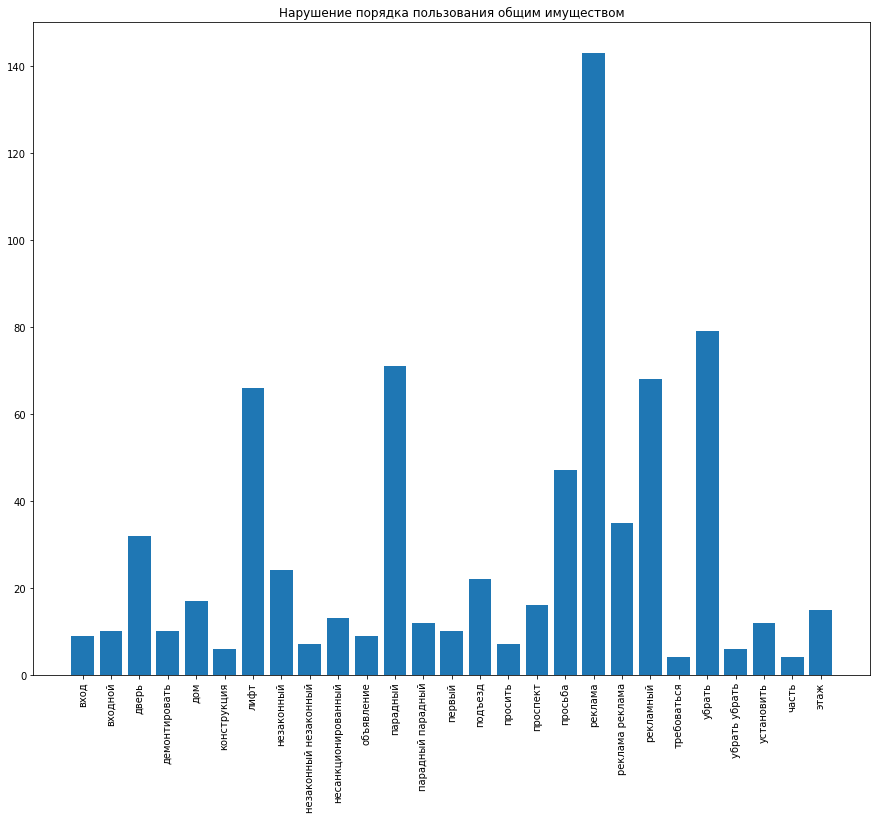

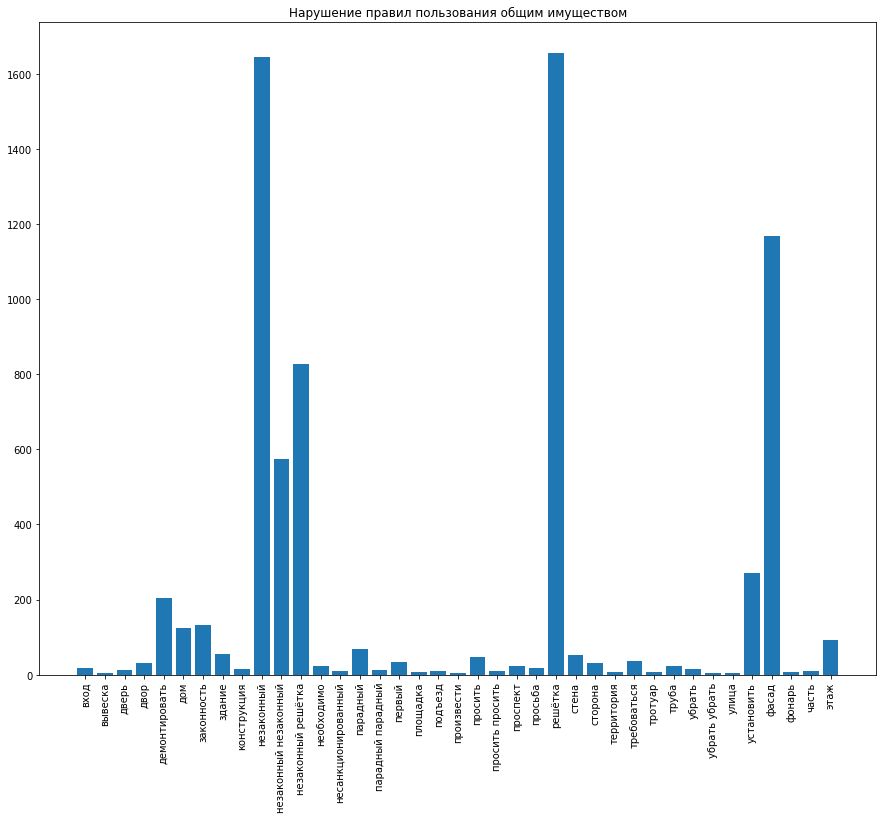

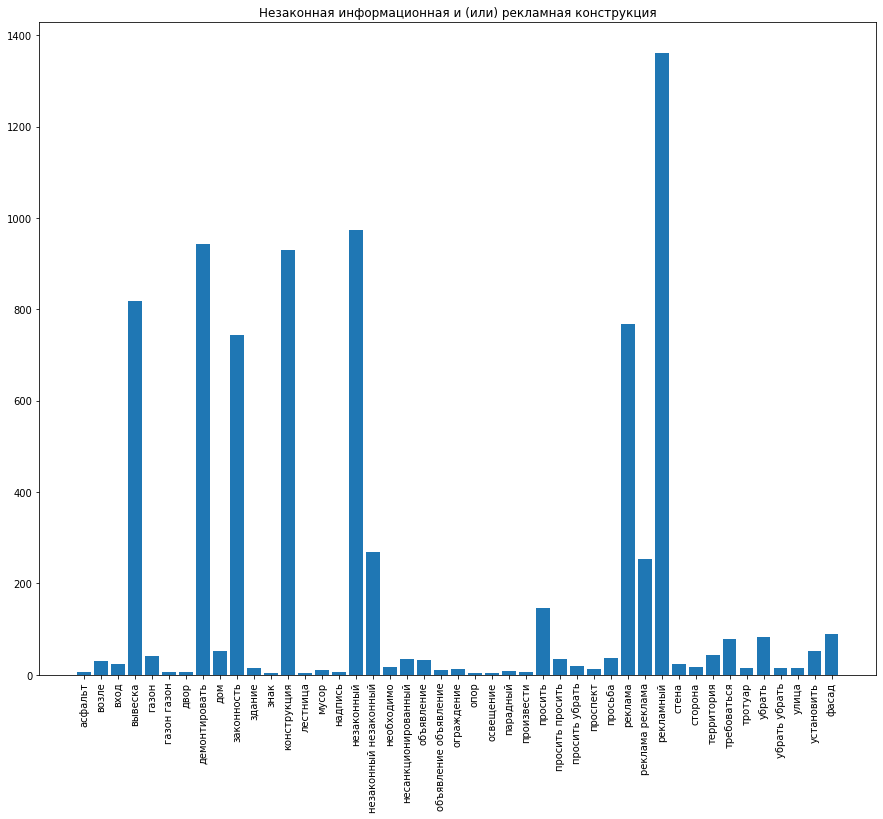

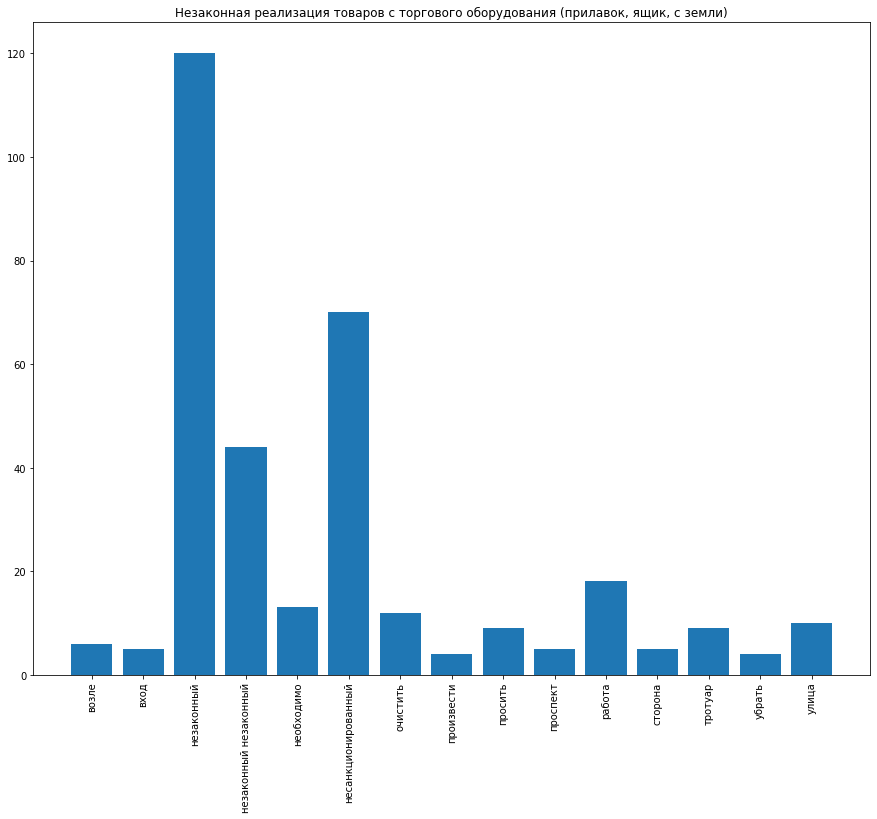

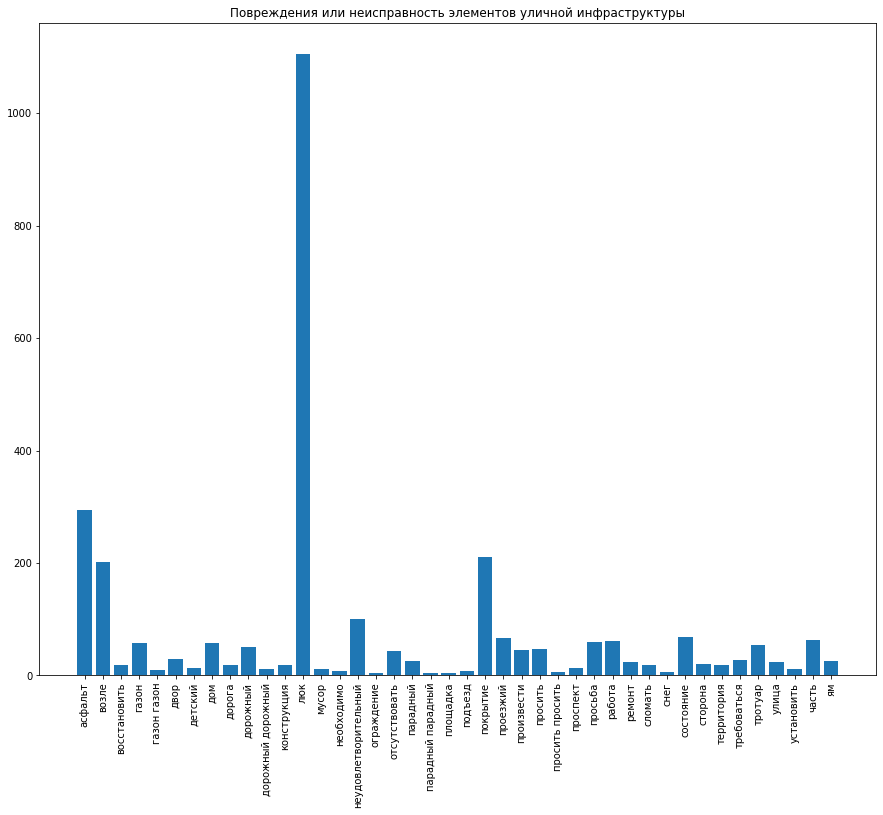

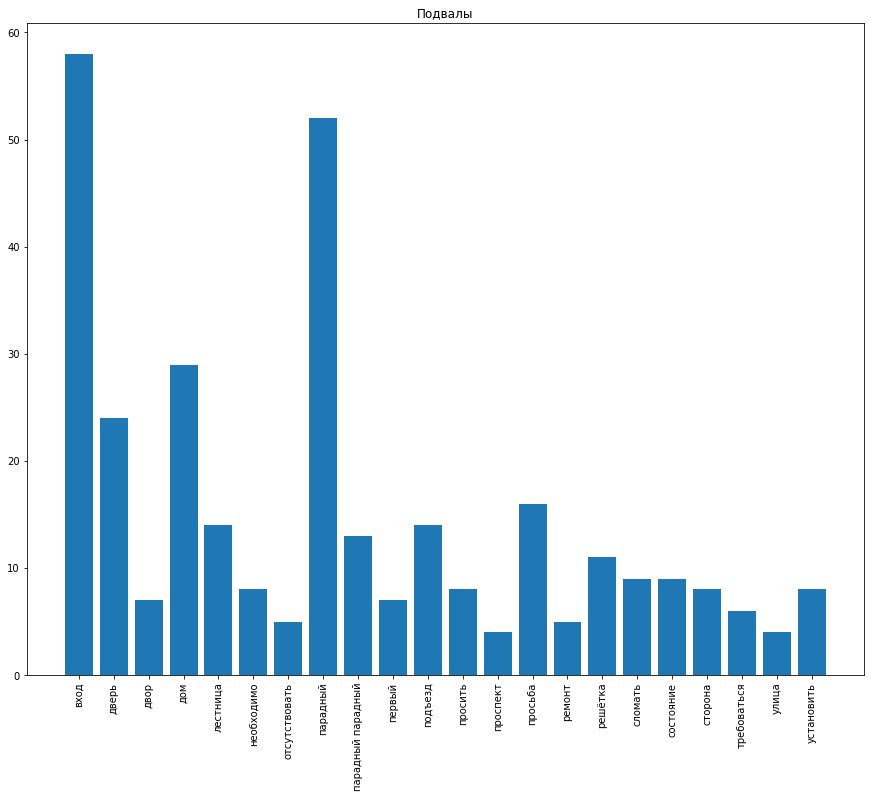

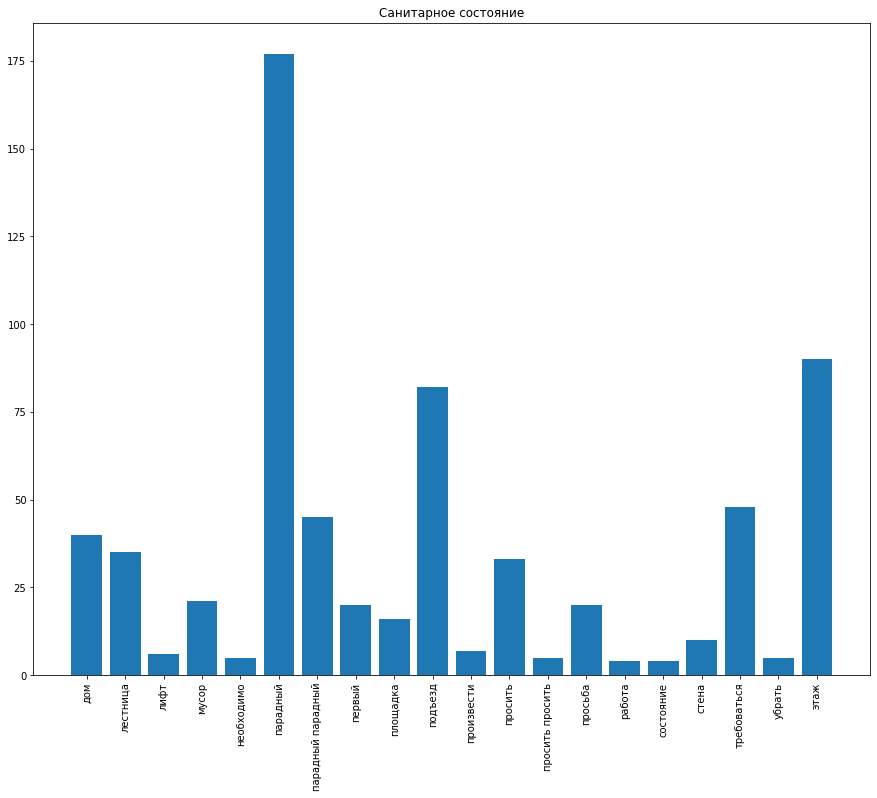

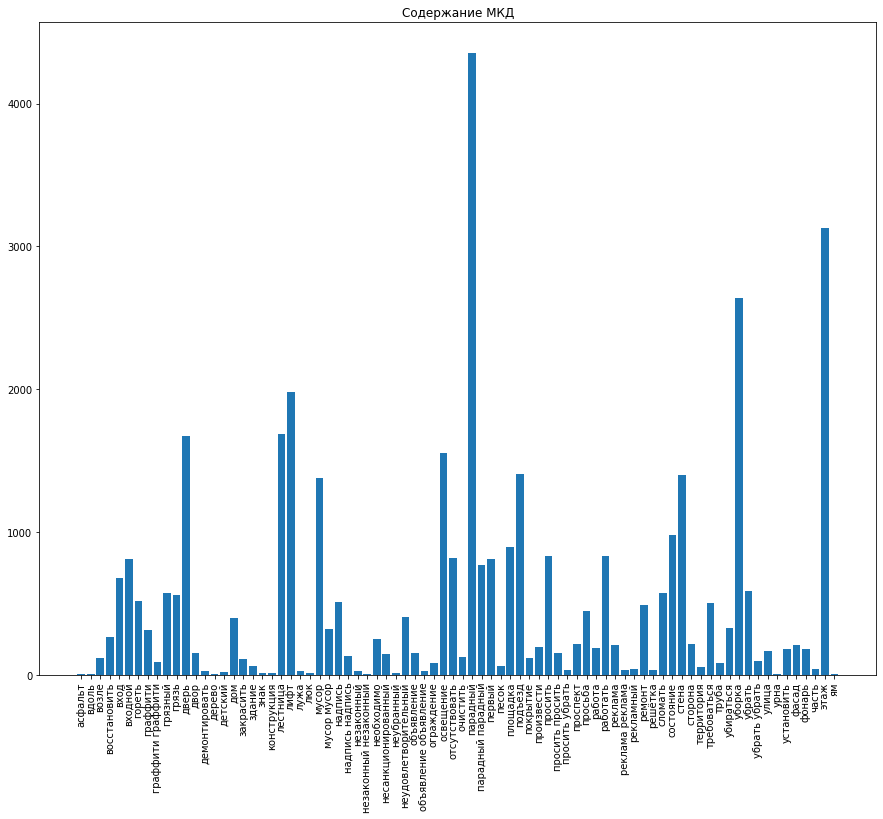

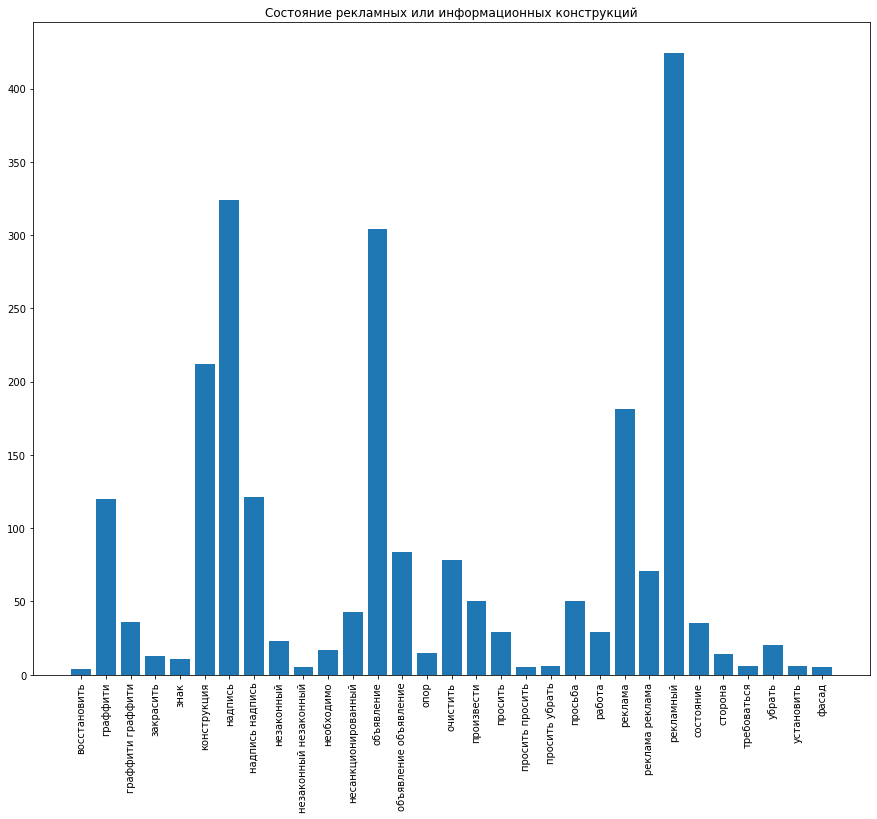

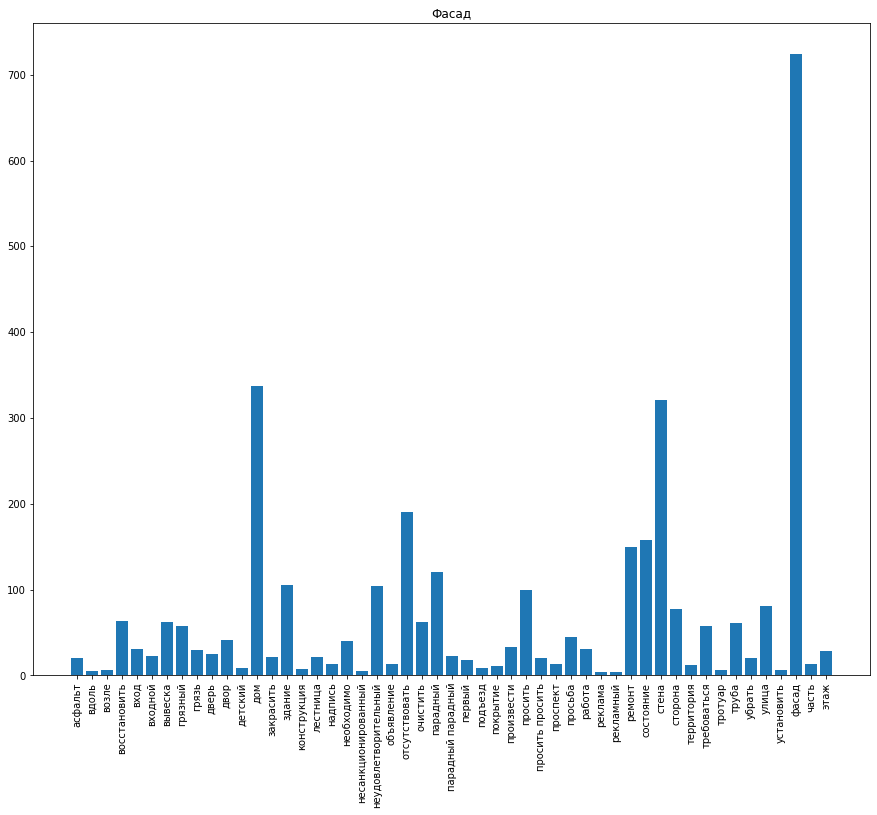

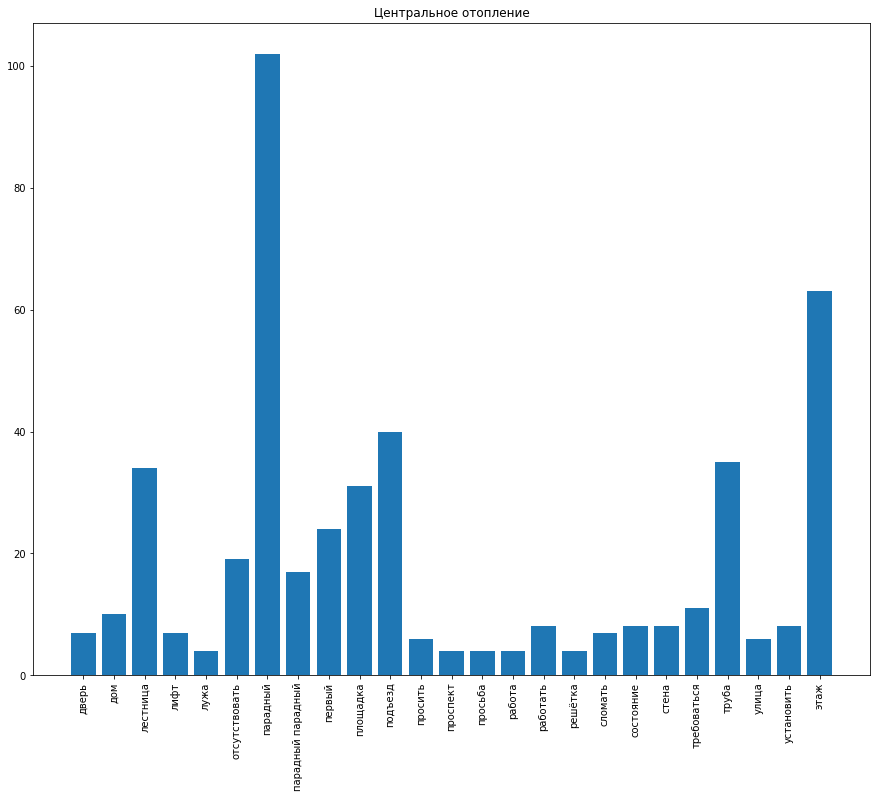

In [15]:
#визуализация
for i in n_df["category_petition"].values:
    x,y = plott(i)
    plt.figure(figsize=(15,12))
    plt.bar(x,y)
    plt.title(i)
    plt.xticks(rotation='vertical')
    plt.show()


### 1.2 WordCloud

In [16]:
cvDF = cvDF.drop(["category_petition"], axis=1) #дропаем целевую переменную для корректной работы визуализации

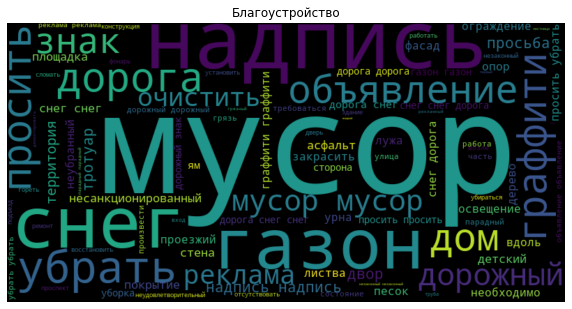

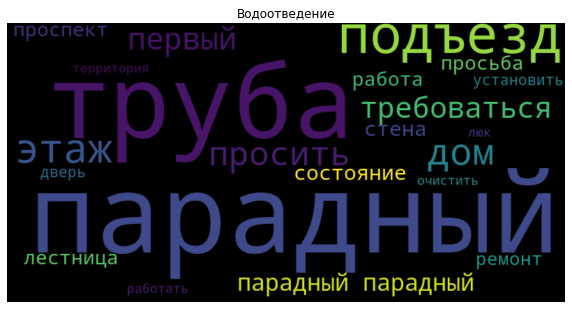

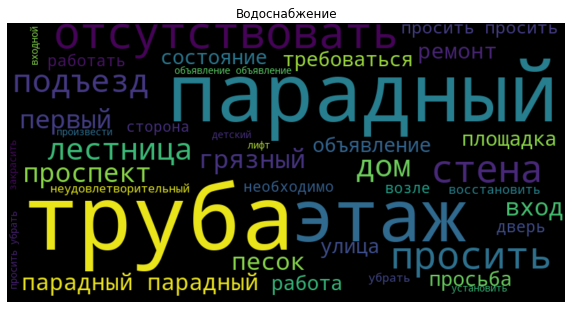

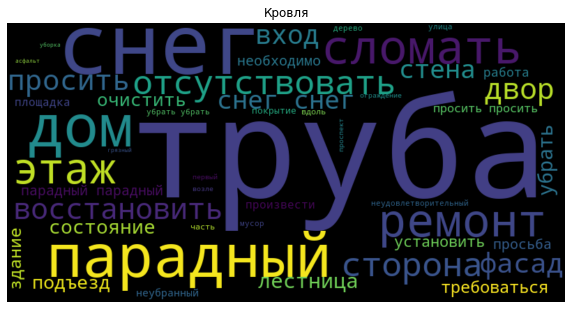

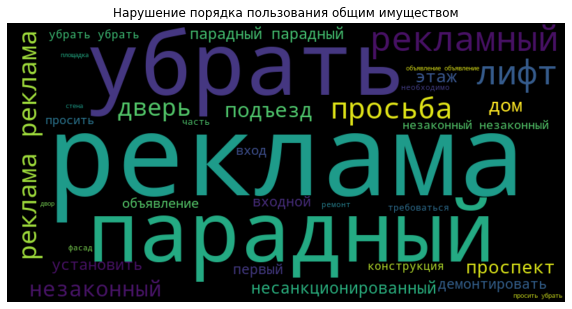

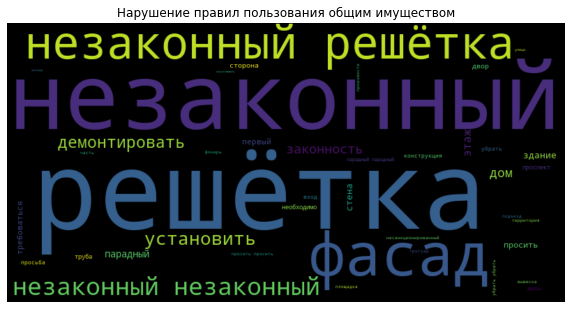

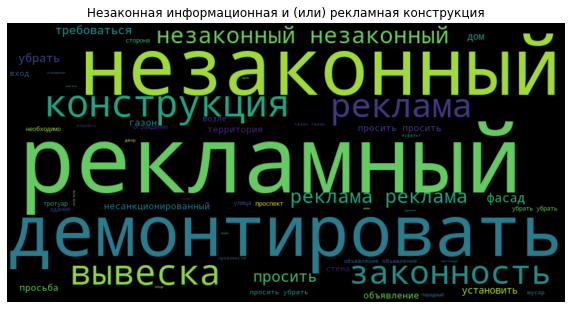

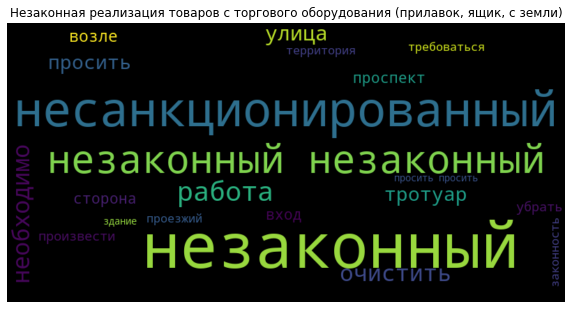

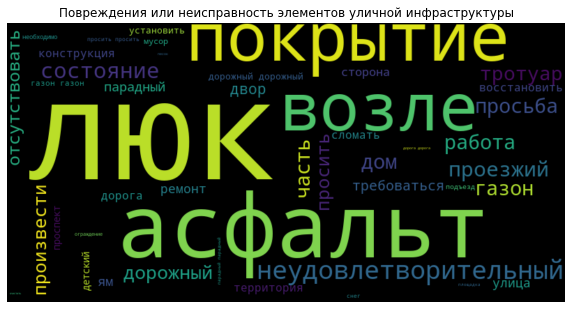

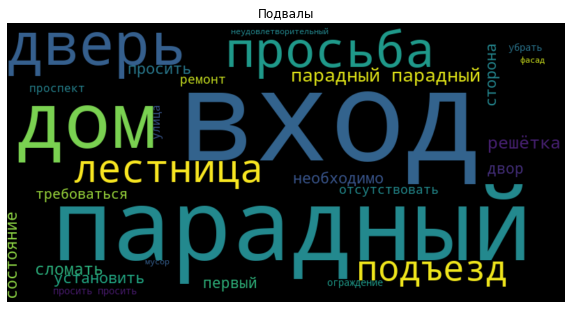

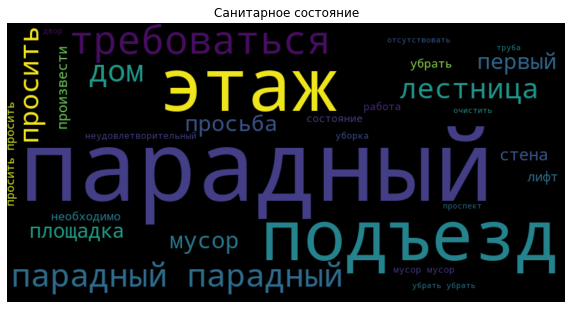

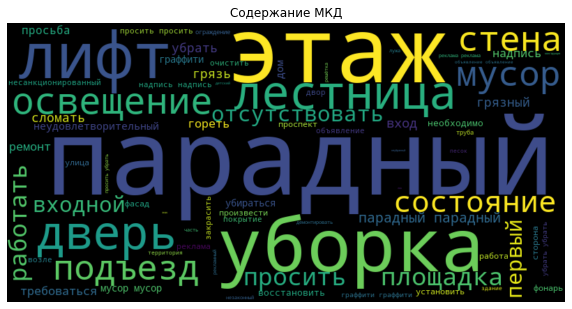

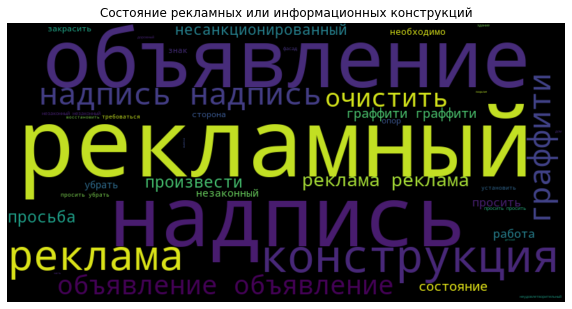

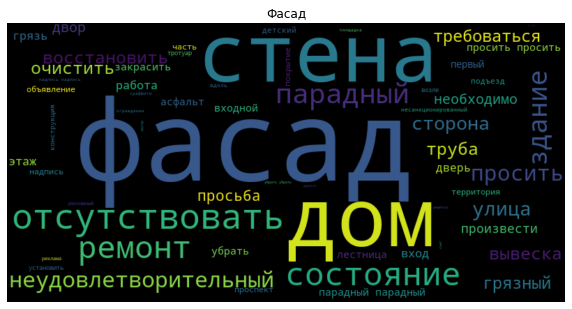

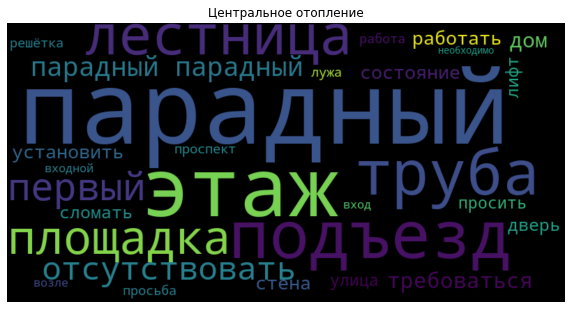

In [17]:
#визуализация облака слов
for c in range(len(cvDF)):
    w=[]
    for i,j in zip(cvDF.T[c].index, cvDF.T[c].values):
            a=[]
            if j > 1:
                a.append(i)
                a.append(j)
                w.append(a)
    pd.DataFrame(w)
    data1 = dict(w)
    try:
        wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data1)
    except ValueError:
        continue
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(n_df['category_petition'][c])
    plt.show()

## 2) Зависимость целевой переменной от текста жалоб

Повторяем проделанное выше с текстами жалоб

### 1.1 Bar Plot

In [18]:
#векторизируем текст для нахождения частоты вхождений слов
cv2 = CountVectorizer(max_features=100)
cvA2 = cv2.fit_transform(n_df["petition_text"]).toarray()

#создаем датафрейм, который будет содержать частоту слов в тексте
cvDF = pd.DataFrame(cvA2, columns=cv2.get_feature_names())
cvDF["category_petition"] = n_df["category_petition"]

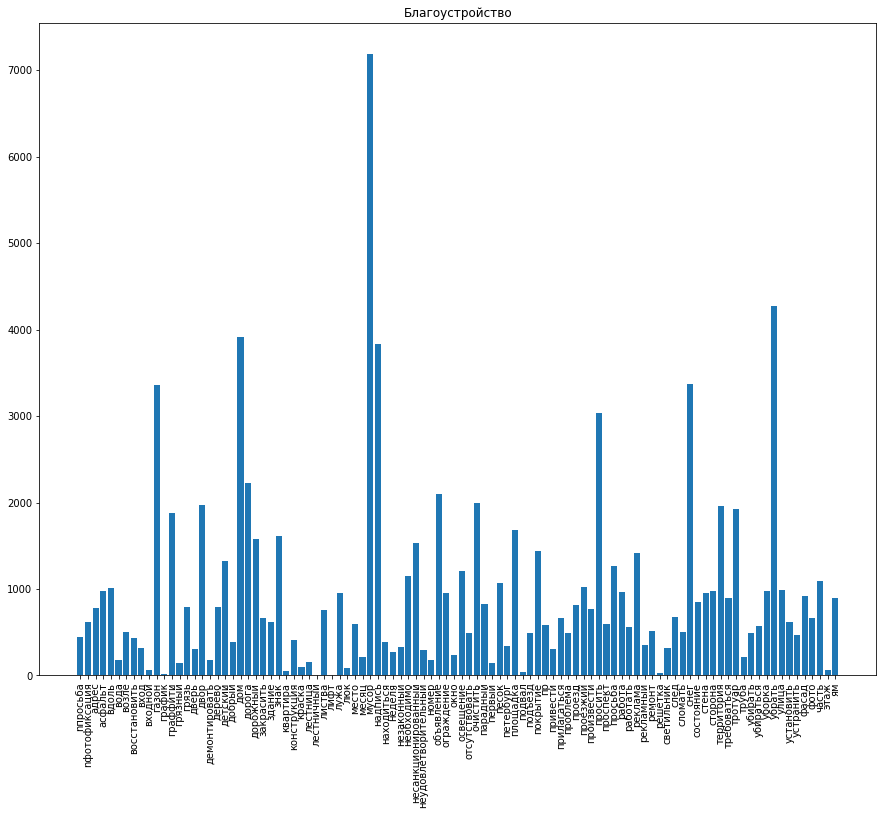

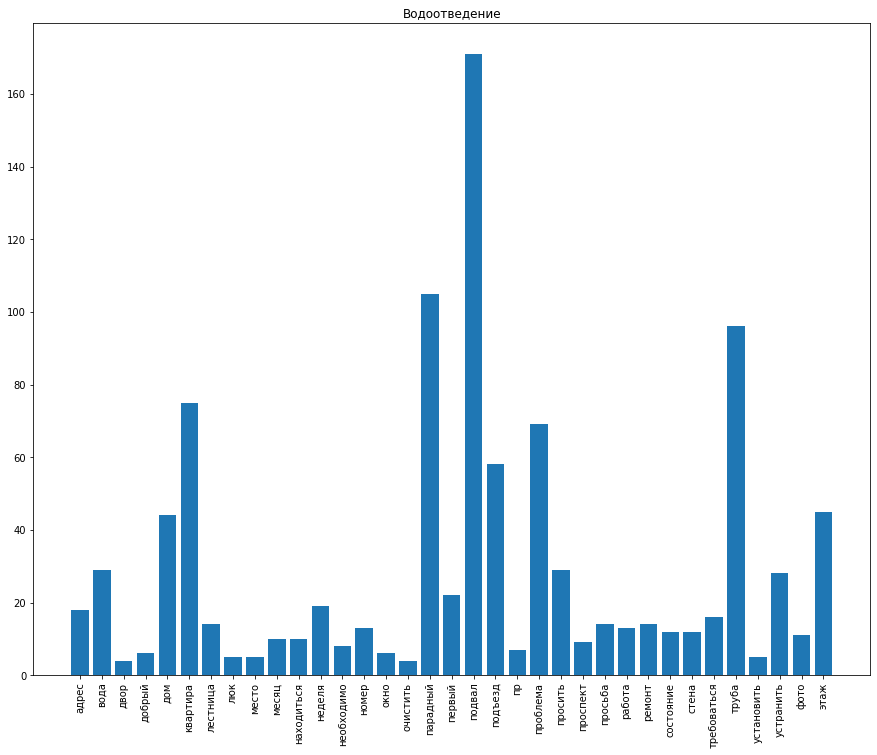

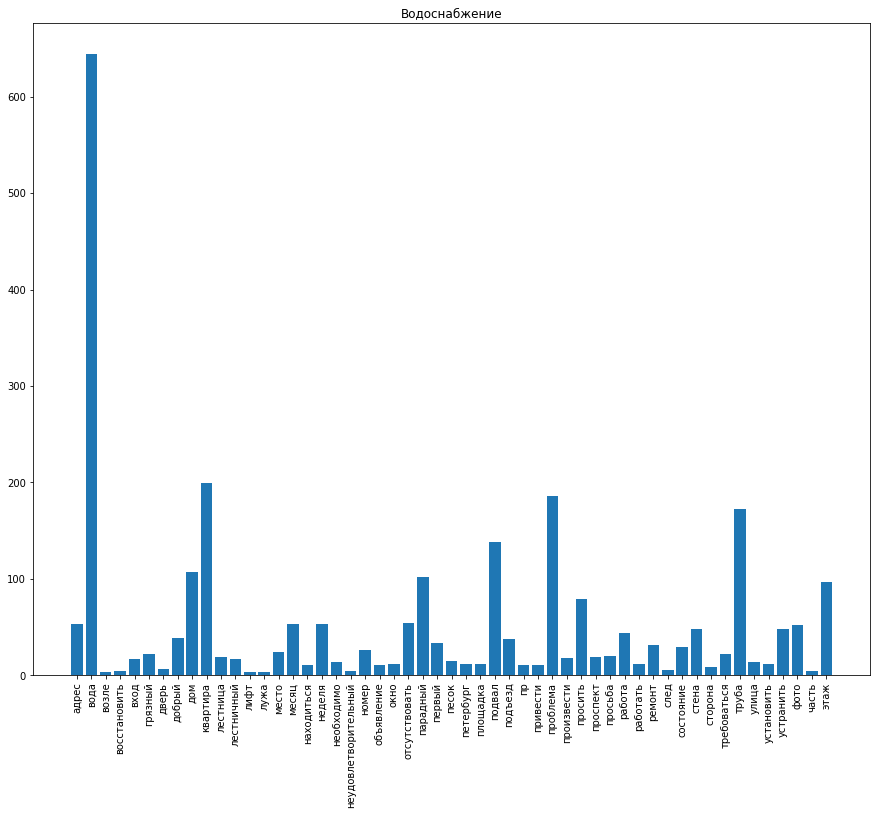

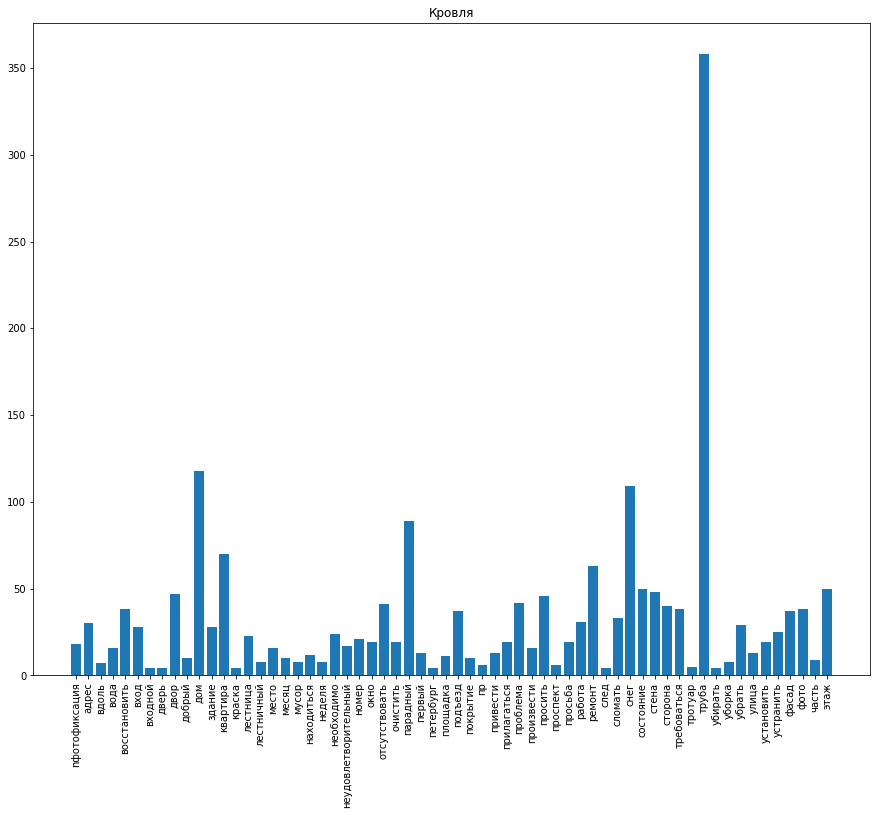

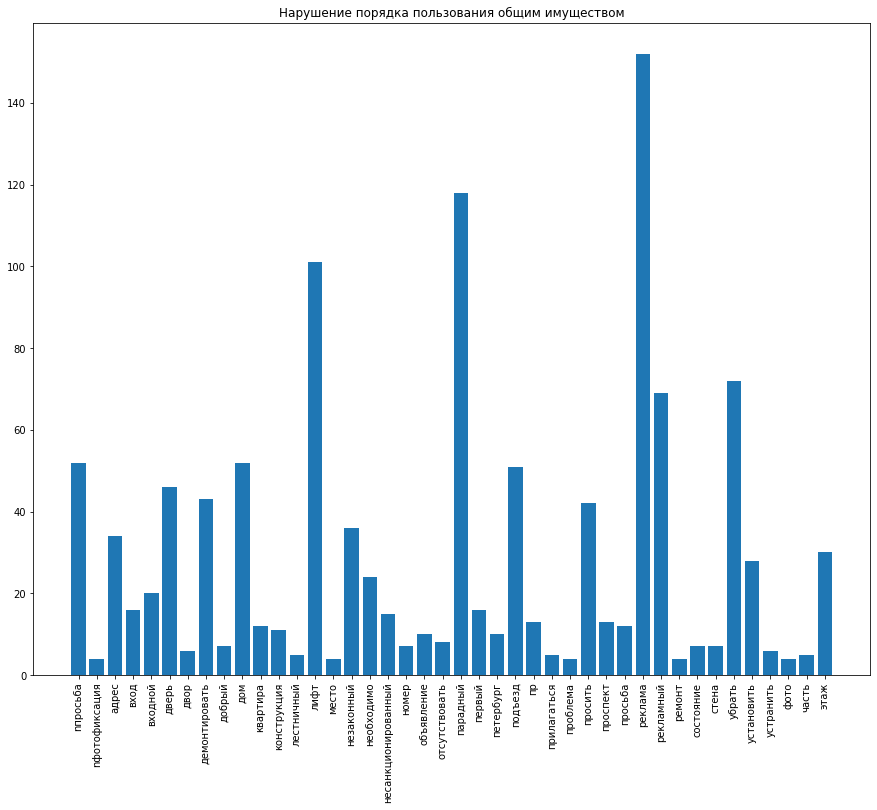

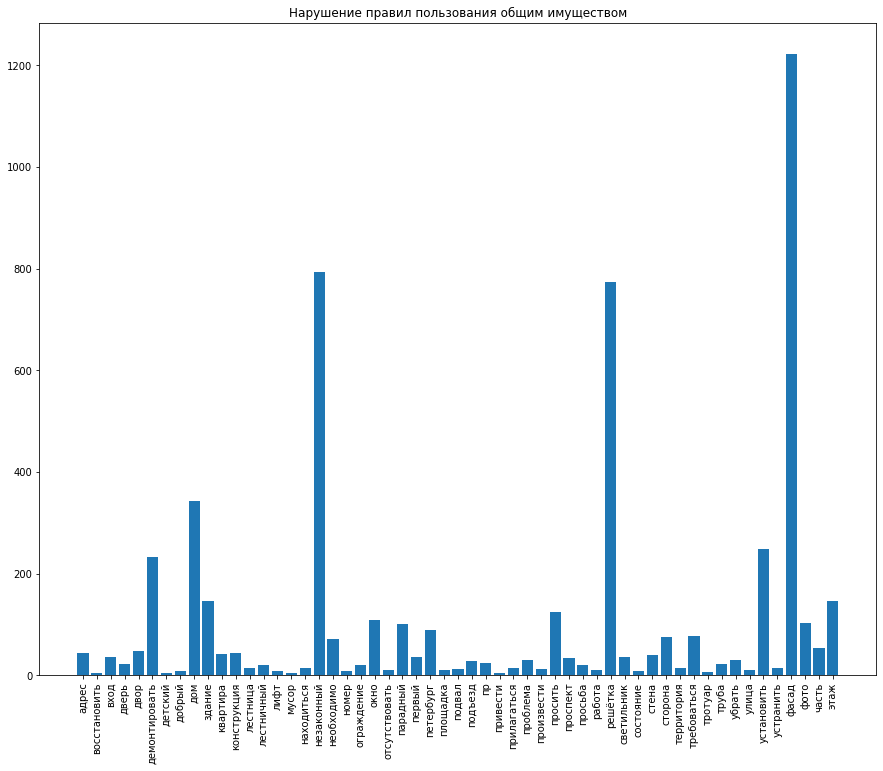

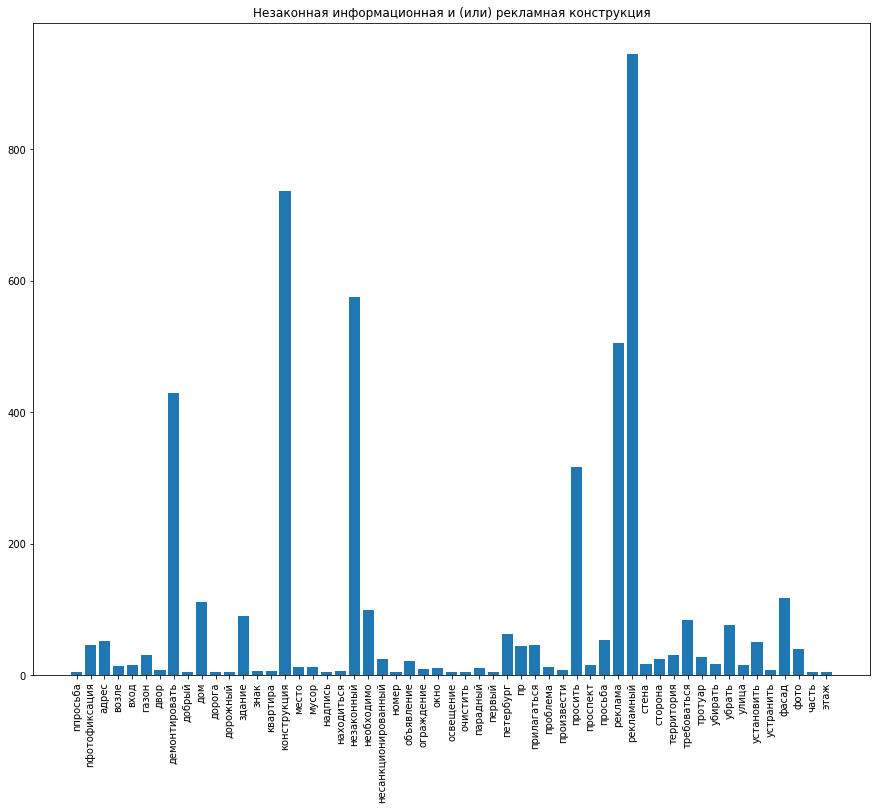

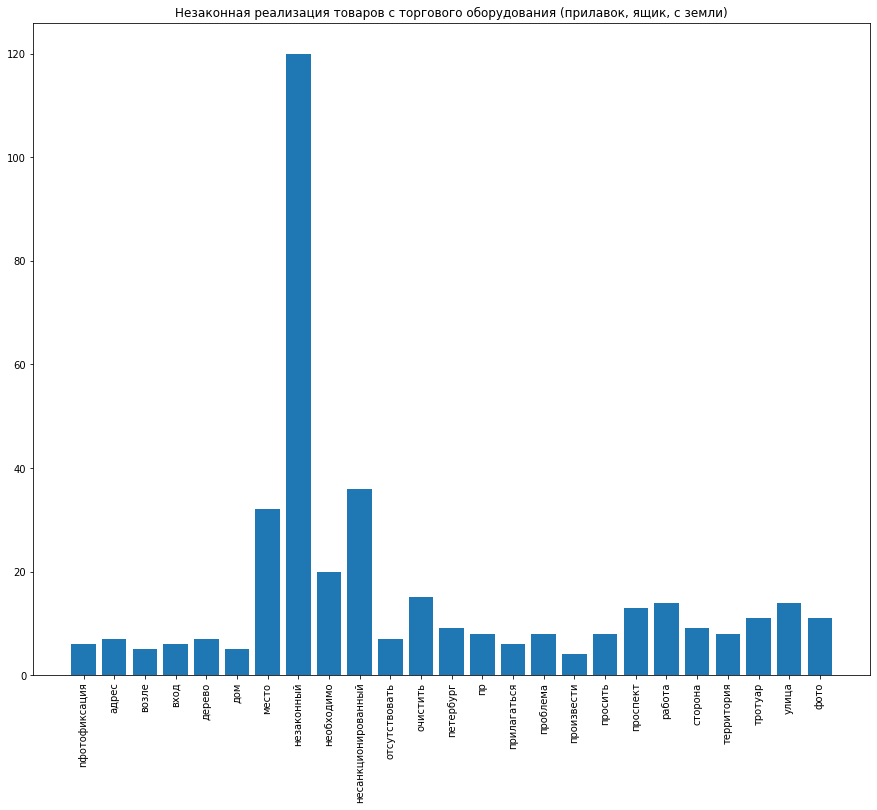

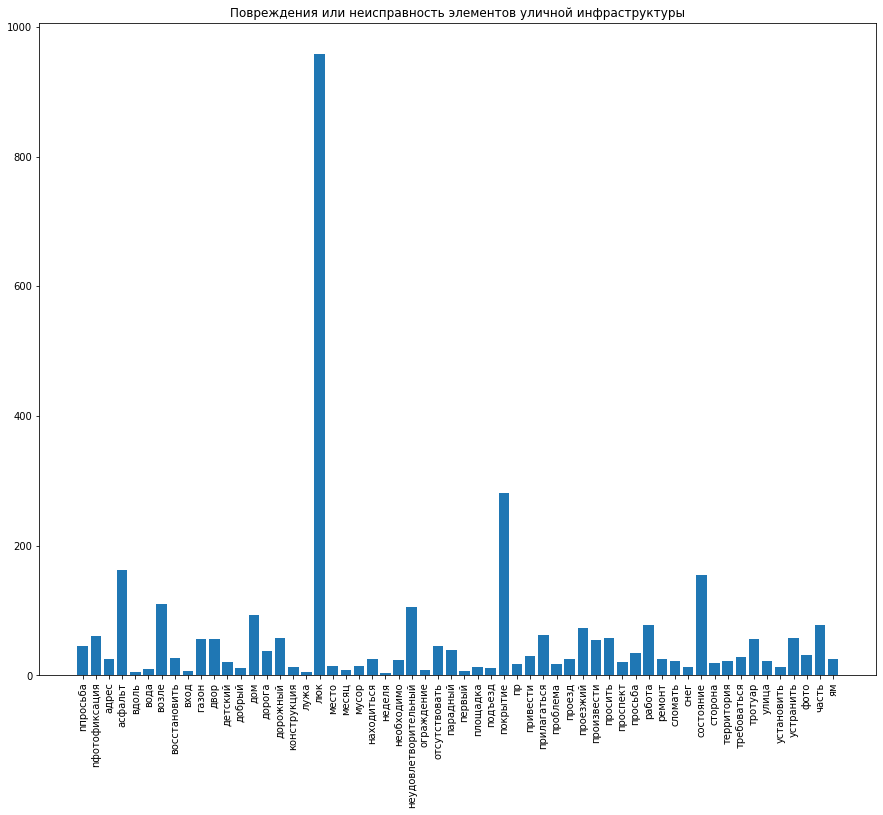

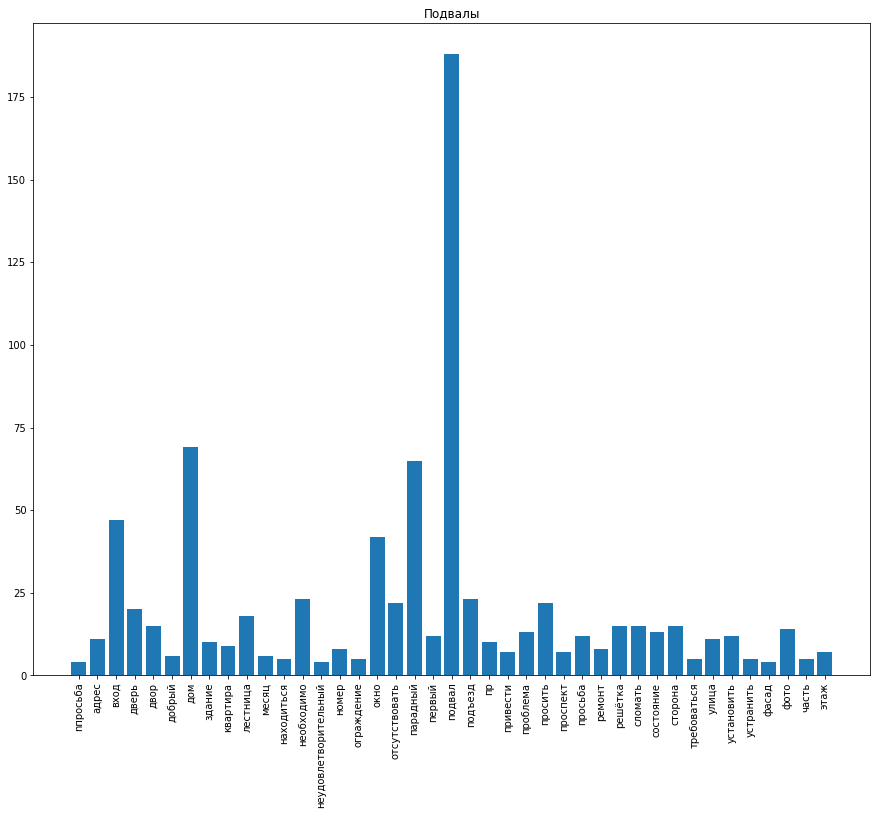

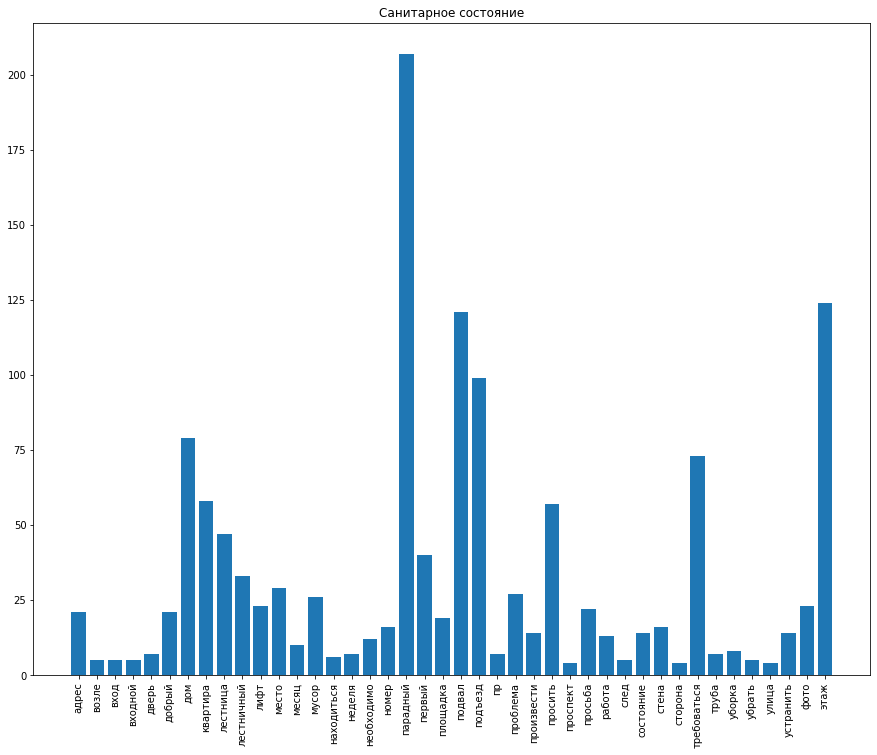

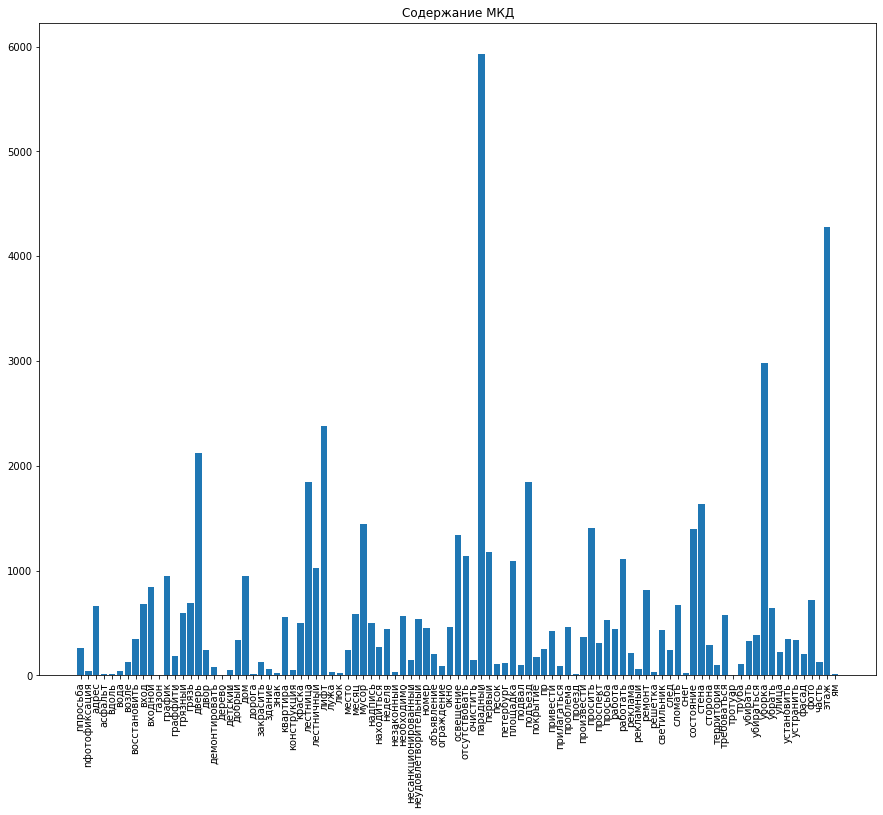

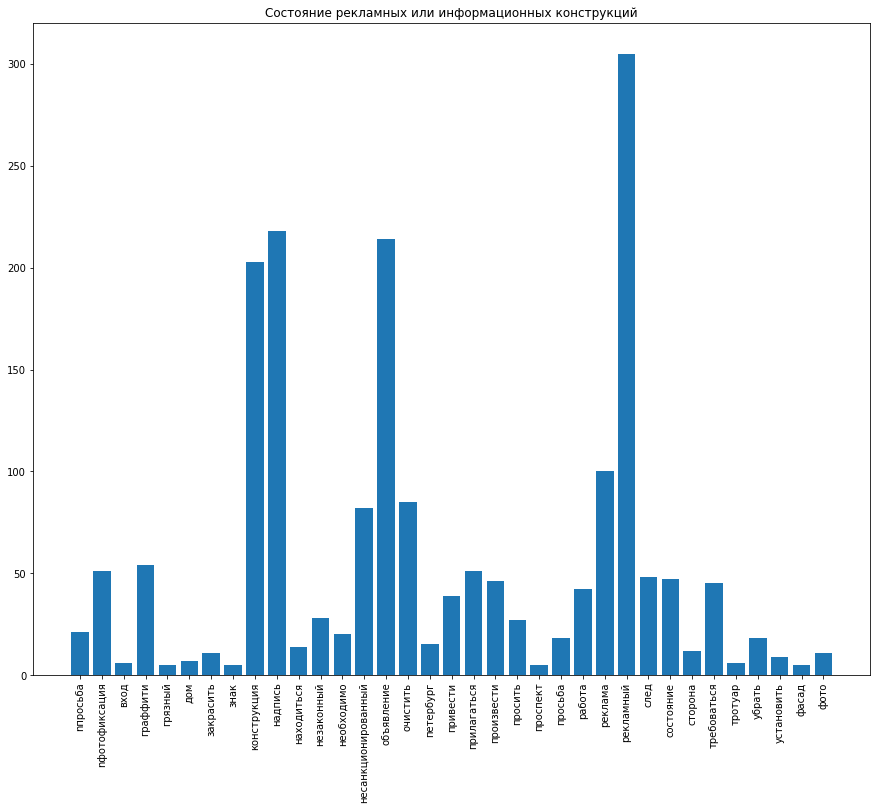

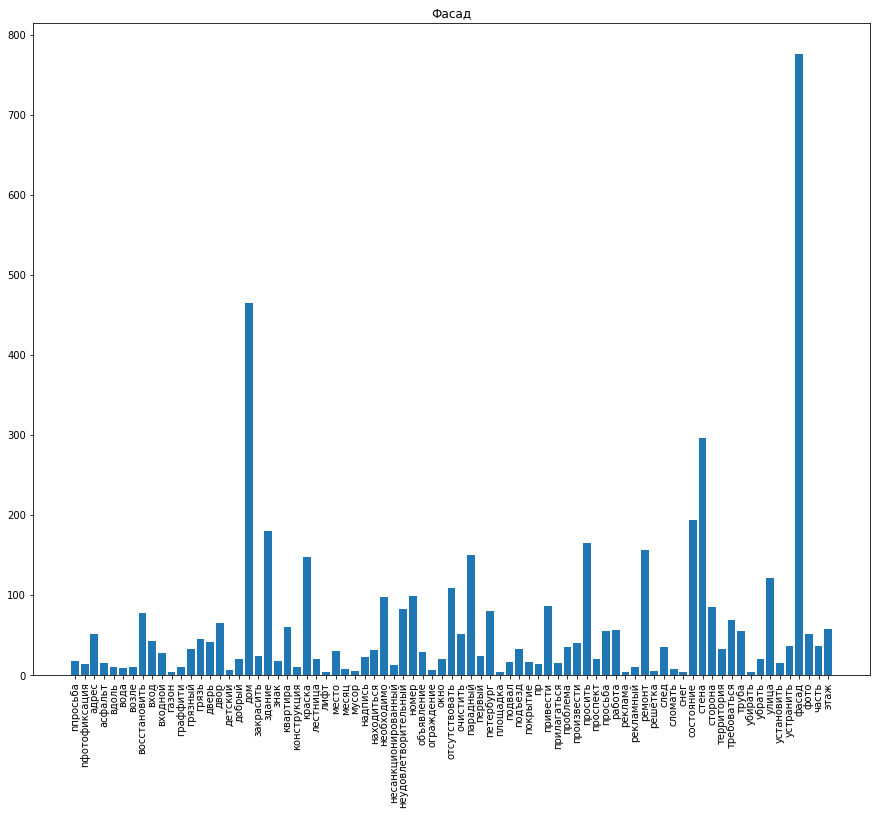

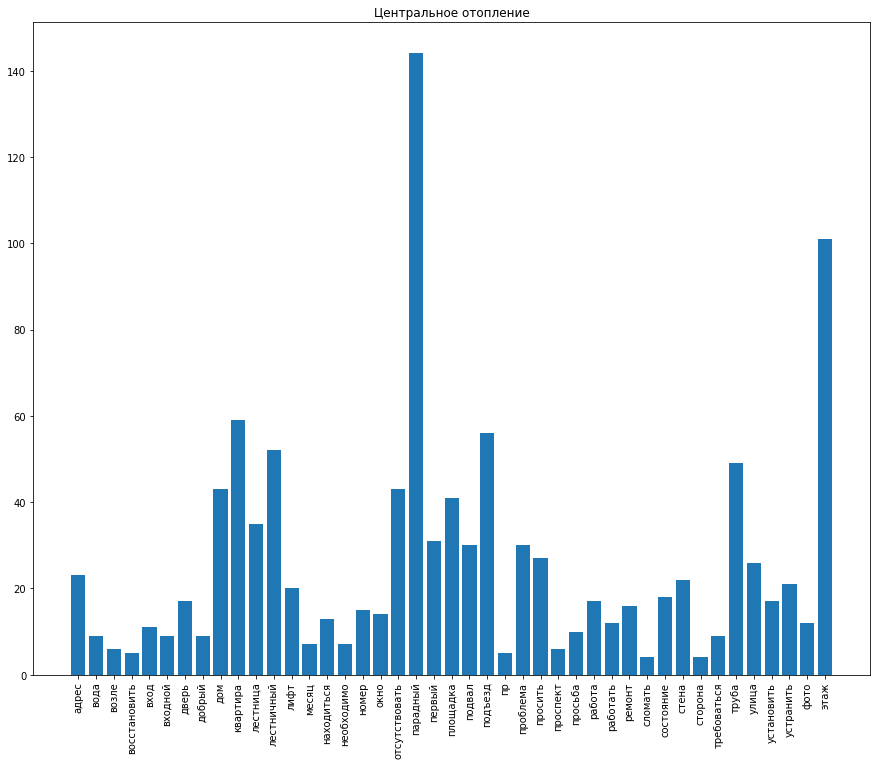

In [19]:
#визуализация
for i in n_df["category_petition"].values:
    x,y = plott(i)
    plt.figure(figsize=(15,12))
    plt.bar(x,y)
    plt.title(i)
    plt.xticks(rotation='vertical')
    plt.show()


### 1.2 WordCloud

In [20]:
cvDF = cvDF.drop(["category_petition"], axis=1) #дропаем целевую переменную для дальнейшей корректной работы визуализации

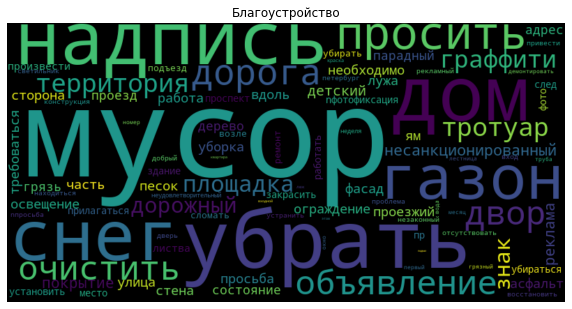

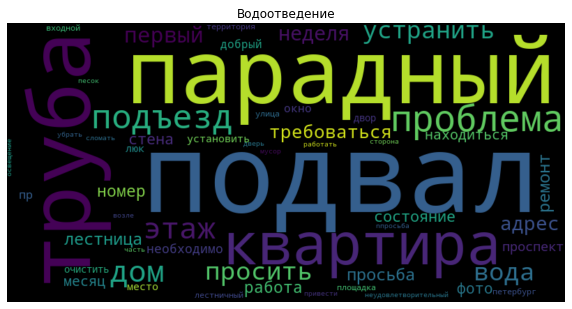

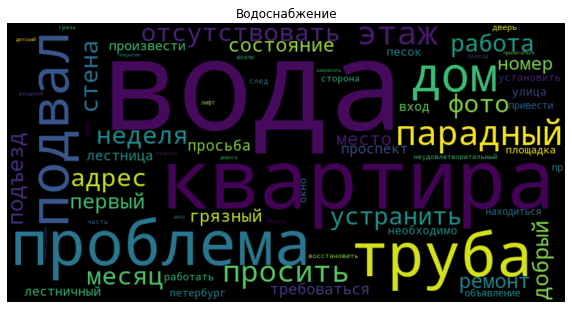

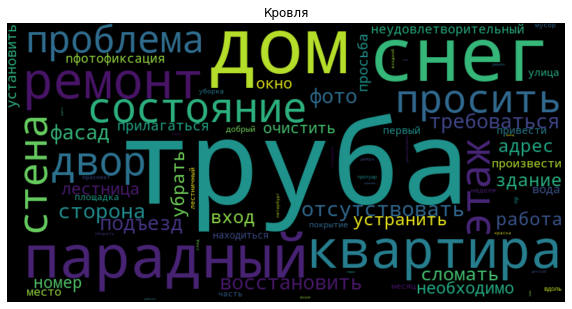

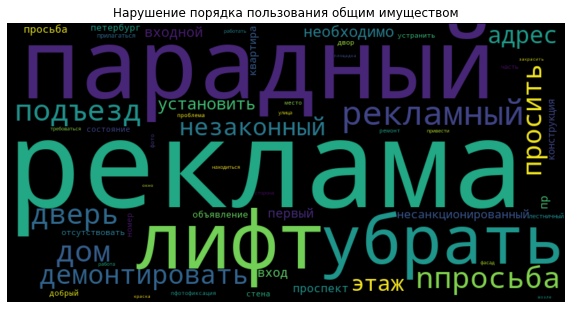

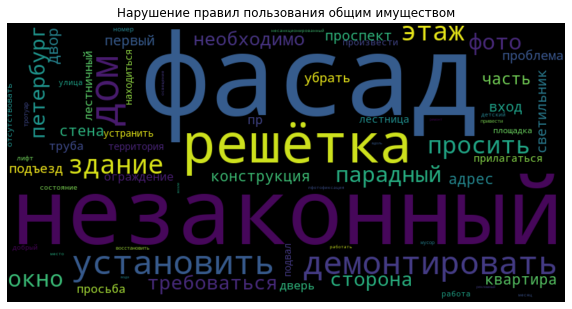

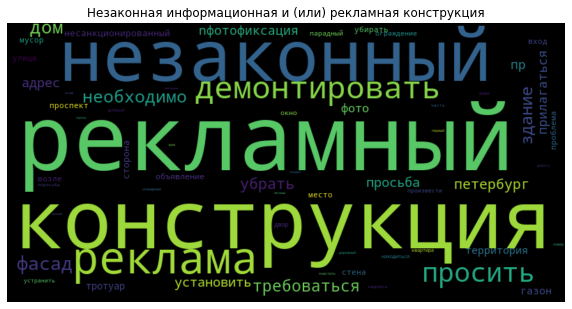

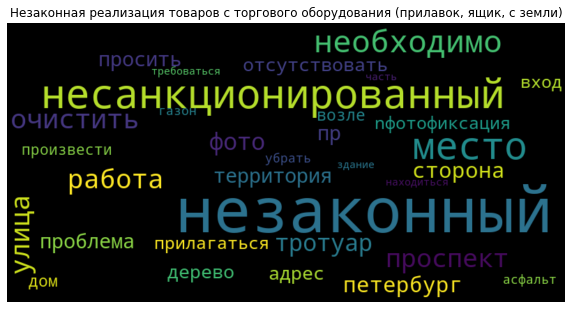

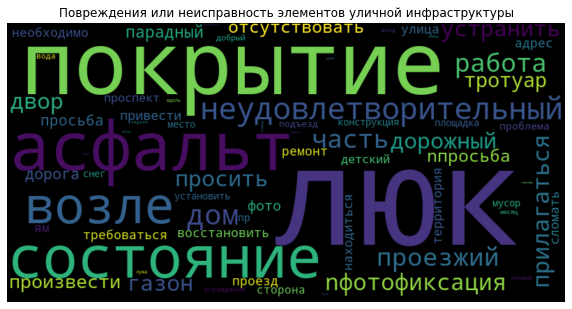

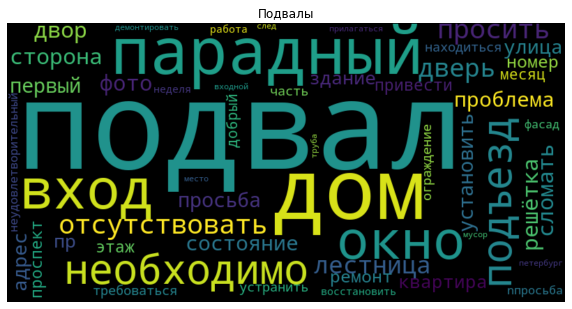

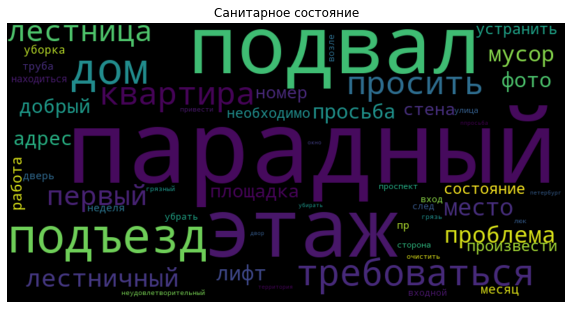

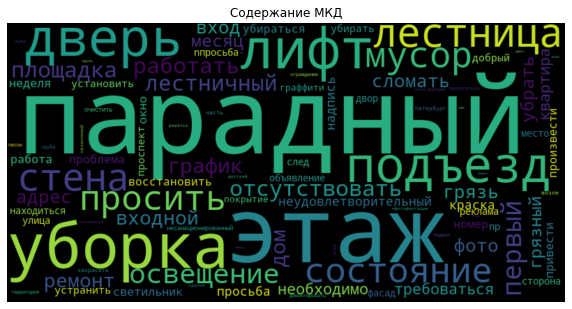

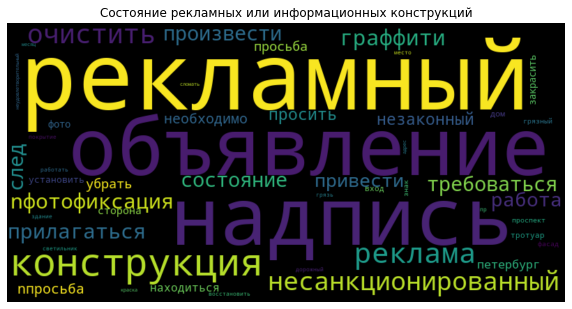

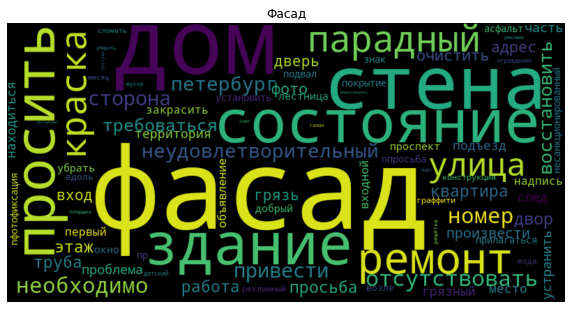

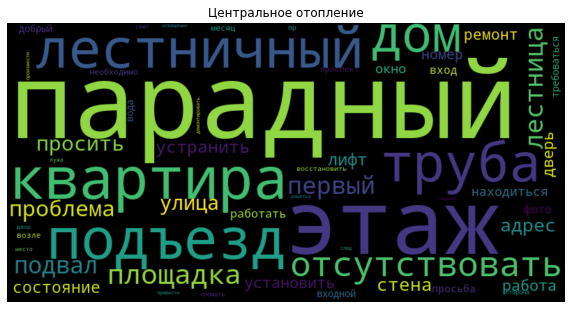

In [21]:
#визуализация облака слов
for c in range(len(cvDF)):
    w=[]
    for i,j in zip(cvDF.T[c].index, cvDF.T[c].values):
            a=[]
            if j > 1:
                a.append(i)
                a.append(j)
                w.append(a)
    pd.DataFrame(w)
    data1 = dict(w)
    try:
        wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data1)
    except ValueError:
        continue
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(n_df['category_petition'][c])
    plt.show()

## 3) Зависимость целевой переменной от месяца подачи жалобы

Для изображения зависимости целевой переменной от месяца подачи жалобы будем использовать только Bar Plot

In [22]:
#векторизируем текст для нахождения частоты вхождений слов
cv3 = CountVectorizer(ngram_range=(1,1))
cvA3 = cv3.fit_transform(n_df["month"]).toarray()

#создаем датафрейм, который будет содержать сколько поступало жалоб в той или иной месяц и по какой категории
cvDF = pd.DataFrame(cvA3, columns=cv3.get_feature_names())
cvDF["category_petition"] = n_df["category_petition"]

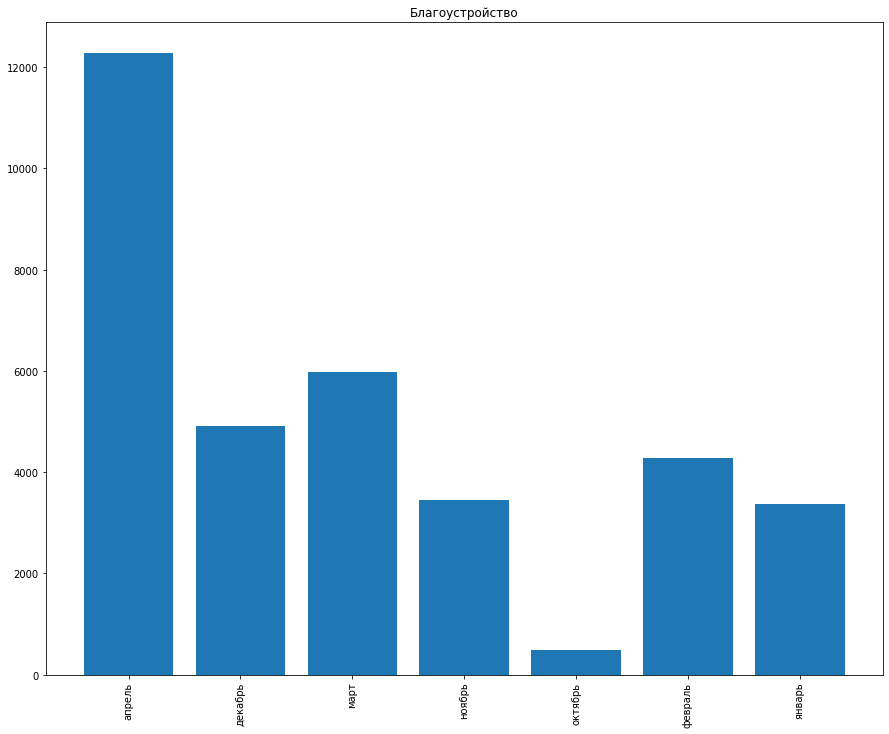

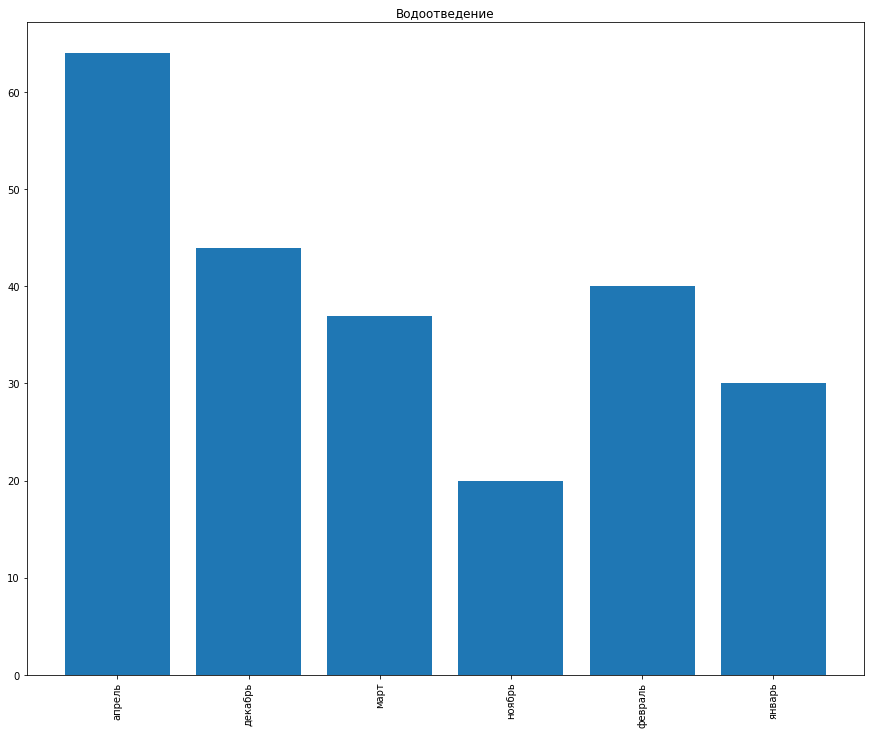

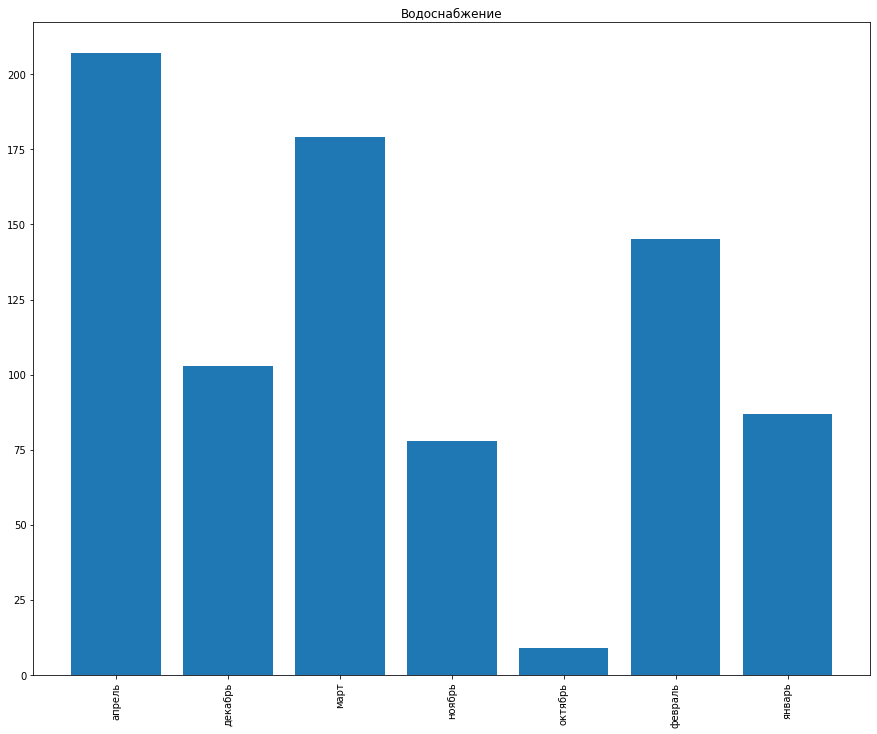

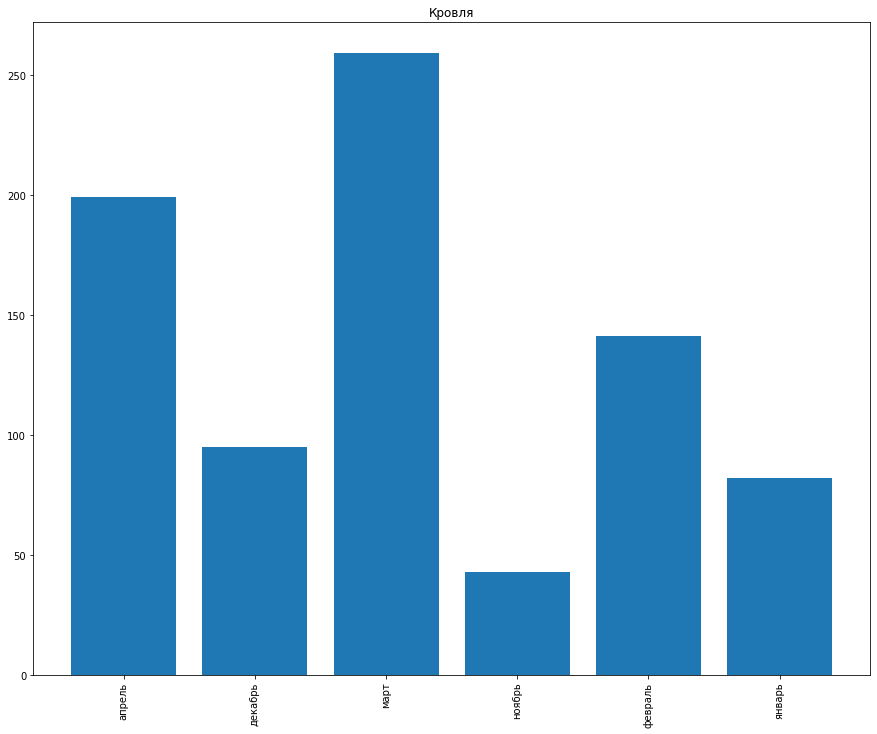

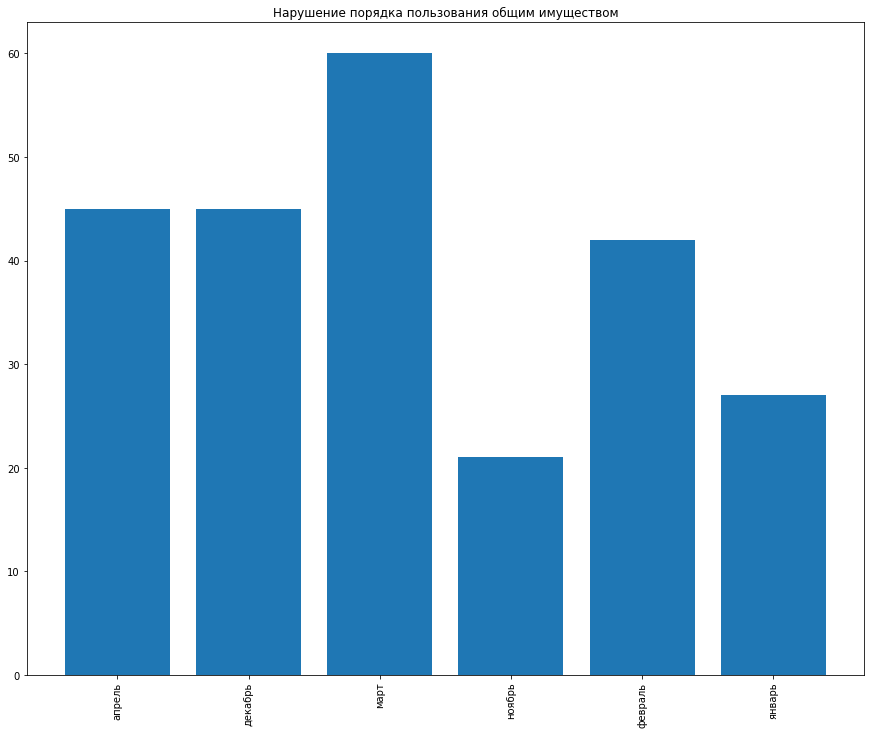

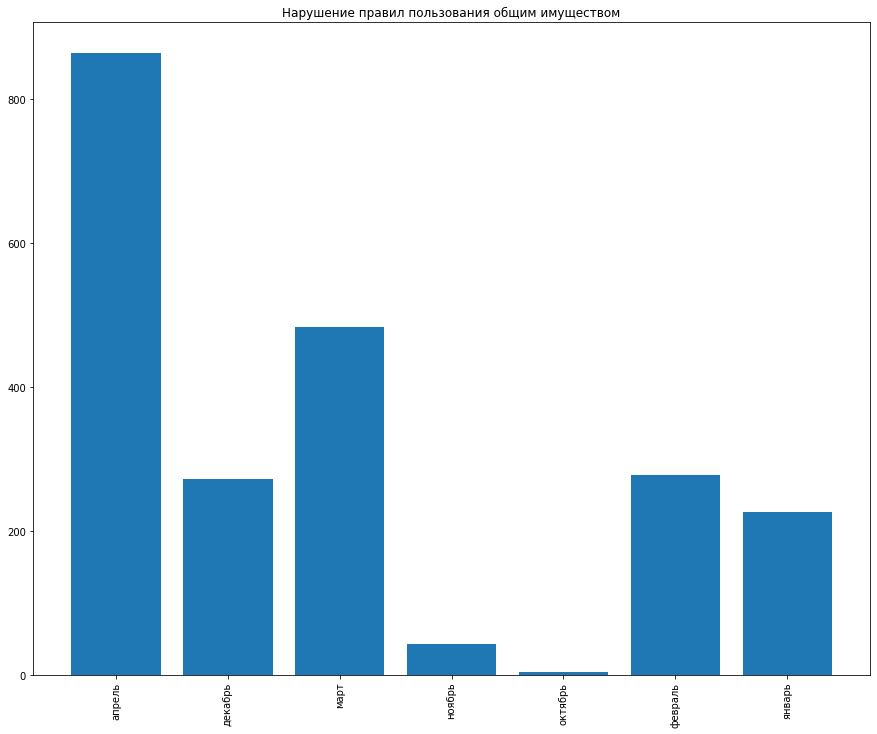

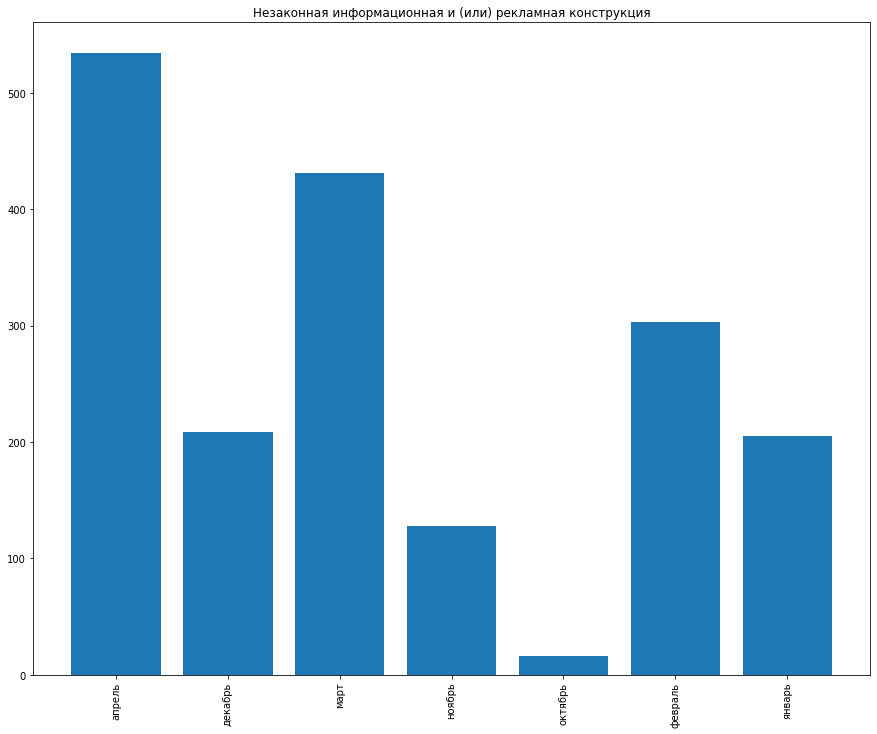

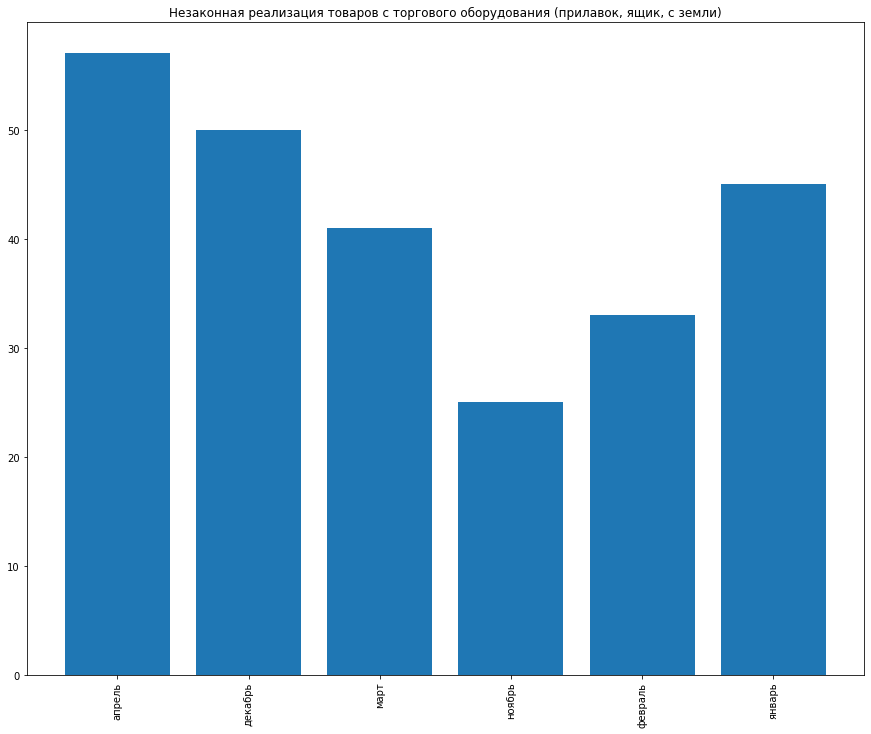

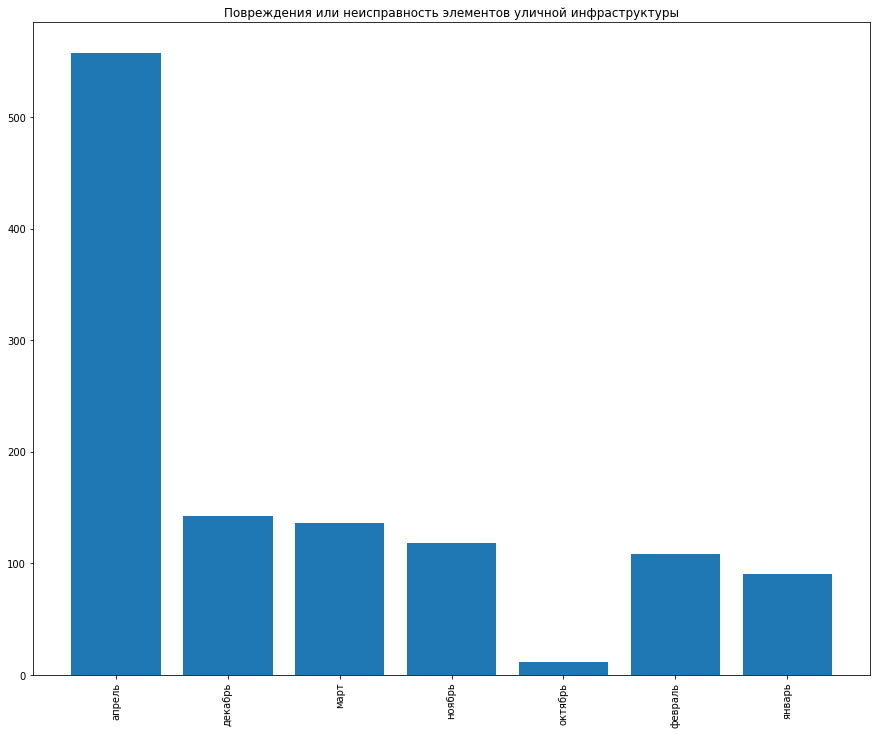

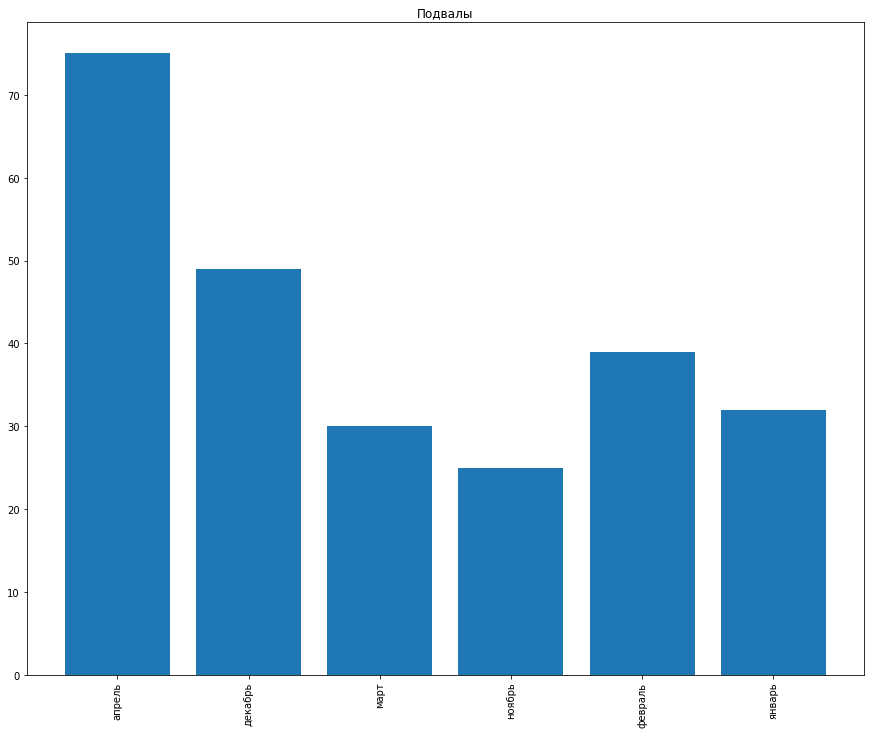

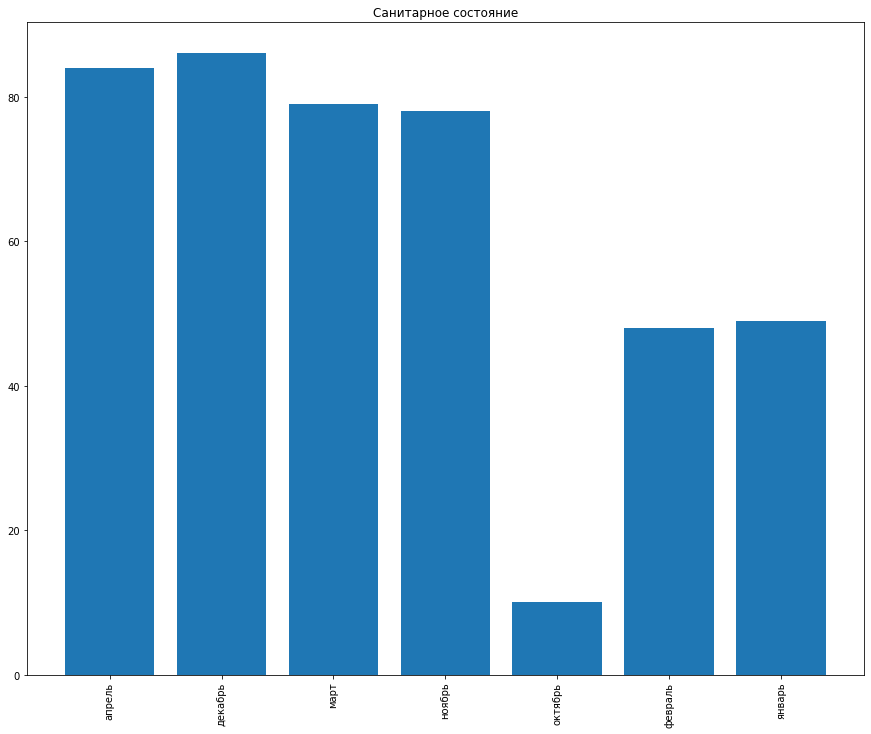

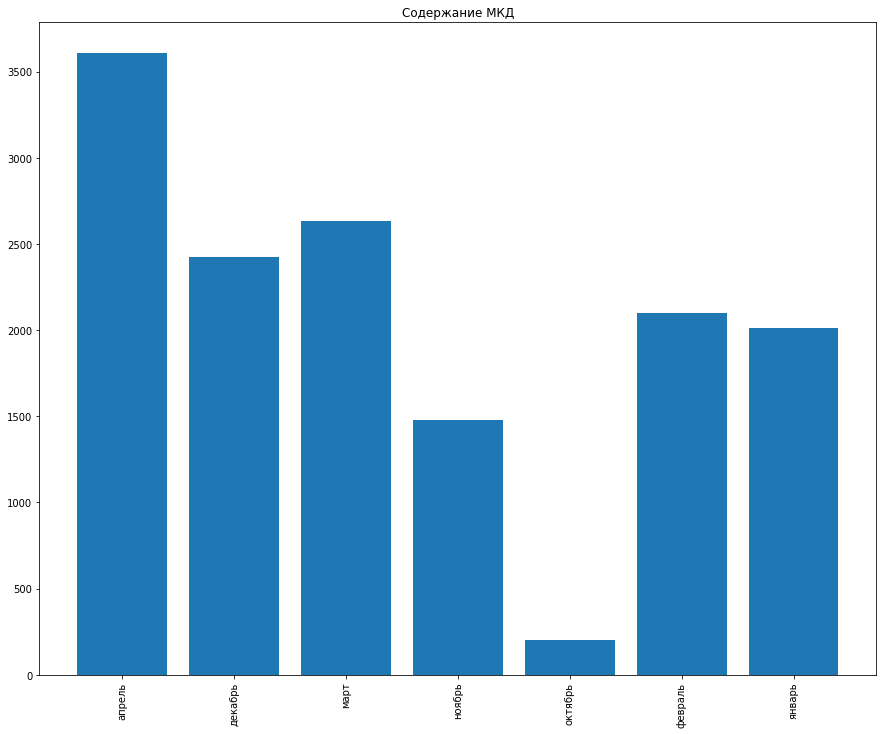

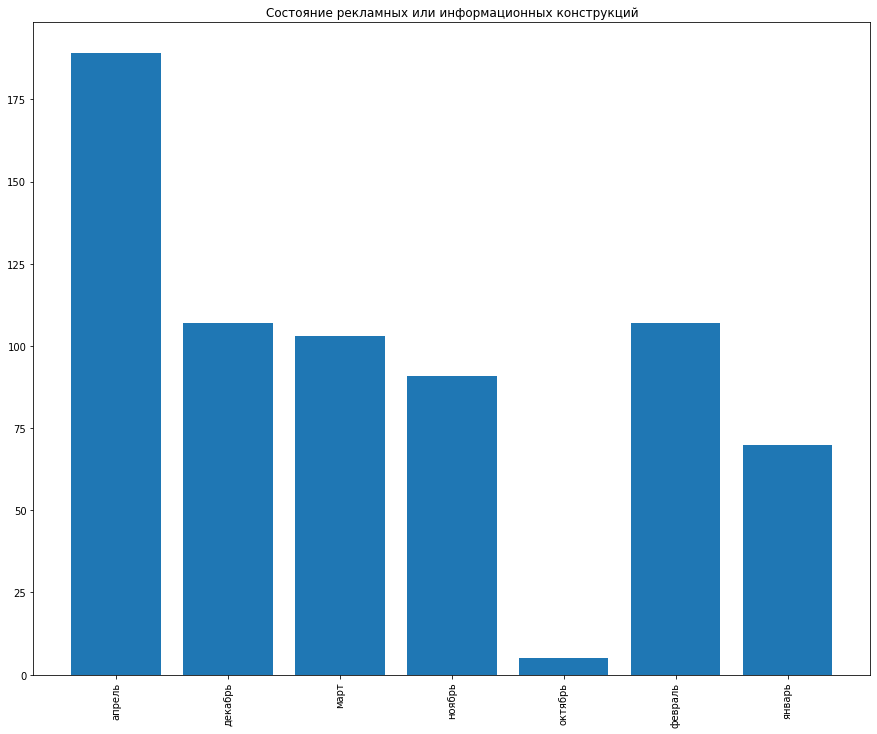

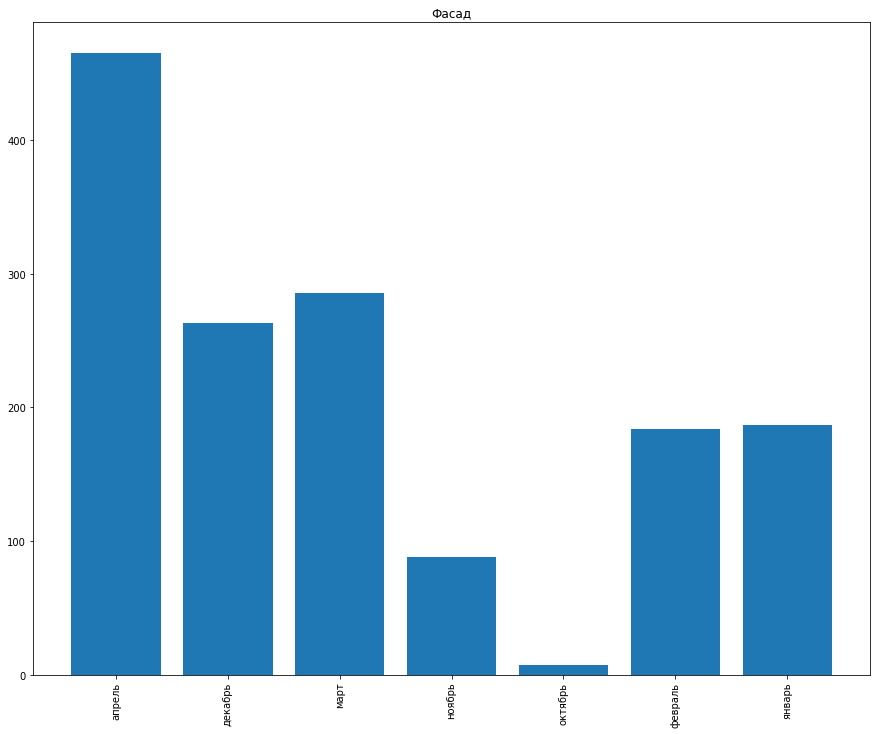

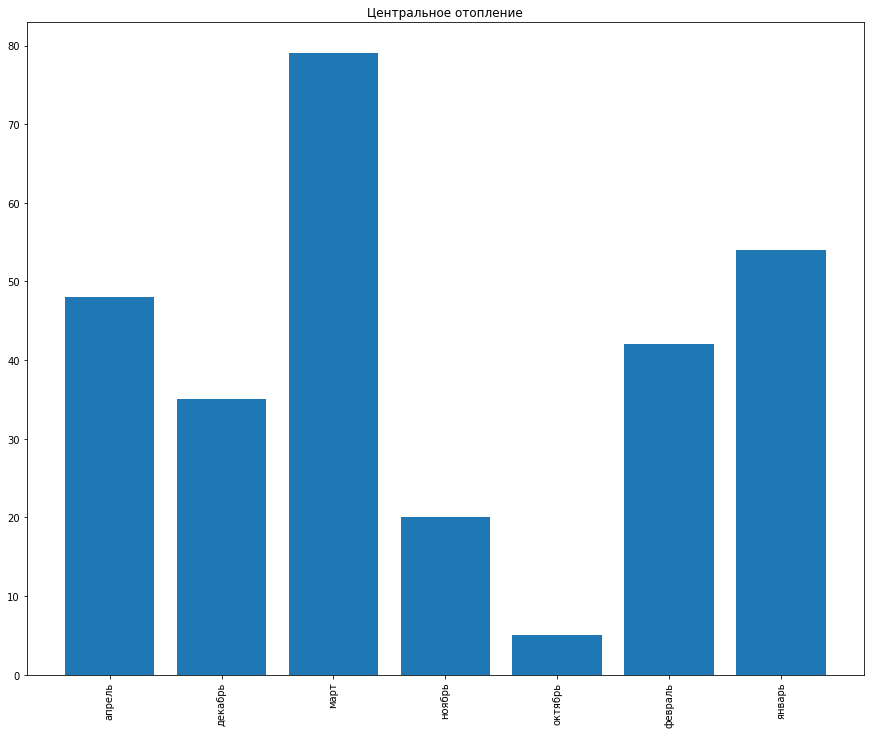

In [23]:
#визуализация
for i in n_df["category_petition"].values:
    x,y = plott(i)
    plt.figure(figsize=(15,12))
    plt.bar(x,y)
    plt.title(i)
    plt.xticks(rotation='vertical')
    plt.show()

## Вывод:
На данном этапе, используя гистограммы и облако слов, мы провизуализировали следующие зависимости:
- категории обращения и ключевые слова
- категории обращения и месяца обращения
- категории обращения и текста обращения


# 

# 3.2. Векторизация текстов

## На этом этапе мы:
- проведем операцию векторизации для текстов обращений граждан несколькими способами.

Векторизация – процесс преобразования токена в числовой массив, который представляет его свойства. В контексте задачи вектор уникален для каждого токена.

##### Мы будем использовать:

1) HashingVectorizer

1) CountVectorizer

2) TF-IDF


## 1) HashingVectorizer

HashingVectorizer - преобразовывает коллекцию текстовых документов в матрицу вхождений токенов. Он превращает набор текстовых документов в матрицу scipy.sparse, содержащую количество вхождений токенов (или двоичную информацию о вхождениях)

In [50]:
h_vec = HashingVectorizer(n_features=300)
hA = h_vec.fit_transform(n_df['petition_text']).toarray()

In [42]:
hA

array([[-0.01411774, -0.00547853,  0.0290081 , ...,  0.01285347,
         0.00266903,  0.00779637],
       [-0.0077566 ,  0.00258553,  0.03619747, ...,  0.0077566 ,
        -0.00258553,  0.0077566 ],
       [-0.05833844,  0.        ,  0.03014153, ..., -0.00388923,
         0.00291692, -0.01166769],
       ...,
       [ 0.        , -0.00709534, -0.00177384, ..., -0.00354767,
         0.        ,  0.00354767],
       [-0.01513284, -0.00453985,  0.11500956, ...,  0.15511157,
         0.00302657,  0.00226993],
       [-0.28762223,  0.0082968 ,  0.04701517, ..., -0.01935919,
        -0.0027656 , -0.01106239]])

## 2) CountVectorizer

CountVectorizer преобразует коллекцию текстовых документов в матрицу количества токенов. Он преобразовывает входной текст в матрицу, значениями которой, являются количества вхождения данного ключа(слова) в текст

In [48]:
#векторизация
cv = CountVectorizer()
cvA = cv.fit_transform(n_df['petition_text']).toarray()
#данный датафрейм будеи отображать количество ключевых слов в по каждой категории
cv_dic = pd.DataFrame(cvA, columns=cv.get_feature_names())
#добавляем столбец категории обращения
cv_dic['category_petition'] = n_df['category_petition'].values

In [32]:
#полученный словарь
cv_dic

adm  af  afc  airpods  antistress  arbitr  audi  aпpeль  bb  be  ...  \
0     0   0    1        1           0       1     1       0   0   0  ...   
1     0   0    0        0           0       0     0       0   0   0  ...   
2     0   0    0        0           0       0     0       0   0   3  ...   
3     0   0    0        0           0       0     0       0   0   0  ...   
4     0   0    0        0           0       0     0       0   0   0  ...   
5     0   1    0        0           0       0     0       0   0   0  ...   
6     0   0    0        0           1       0     0       0   0   0  ...   
7     0   0    0        0           0       0     0       0   0   0  ...   
8     0   0    0        0           0       0     0       0   0   0  ...   
9     0   0    0        0           0       0     0       0   0   0  ...   
10    0   0    0        0           0       0     0       0   0   0  ...   
11    0   1    0        0           0       0     0       2   1   1  ...   
12    0   0    0        0           0       0     0       0   0   0  ...   
13    0   0    0        0           0       0     0       0   0   0  ...   
14    1   0    0        0           0       0     0       0   0   0  ...   

    ясно  ясный  яхтенный  ячейка  ящик  ёлка  ёлочка  ёлочный  ёмкость  \
0      0      0        18       0    88     5       1        0        1   
1      0      0         0       0     0     0       0        0        0   
2      0      0         0       0     2     0       0        0        2   
3      0      0         0       0     0     0       0        0        0   
4      0      0         0       0     4     0       0        0        0   
5      0      0         1       0     0     0       0        0        0   
6      0      0         0       0     0     0       0        0        0   
7      0      0         0       0    16     7       0        1        0   
8      1      0         0       0     0     0       0        0        0   
9      0      0         0       1     0     0       0        0        0   
10     0      0         1       0     2     0       0        0        0   
11     1      1         3       1   415     1       0        0        1   
12     0      0         0       0     0     0       0        0        0   
13     0      0         0       0     1     0       0        0        0   
14     0      0         0       0     1     0       0        0        0   

                                    category_petition  
0                                     Благоустройство  
1                                       Водоотведение  
2                                       Водоснабжение  
3                                              Кровля  
4      Нарушение порядка пользования общим имуществом  
5       Нарушение правил пользования общим имуществом  
6   Незаконная информационная и (или) рекламная ко...  
7   Незаконная реализация товаров с торгового обор...  
8   Повреждения или неисправность элементов улично...  
9                                             Подвалы  
10                               Санитарное состояние  
11                                     Содержание МКД  
12  Состояние рекламных или информационных констру...  
13                                              Фасад  
14                              Центральное отопление  

[15 rows x 17229 columns]

## 3) TF-IDF

TF-IDF - это простой и удобный способ оценить важность термина для какого-либо документа относительно всех остальных документов. Если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для того самого документа.

In [35]:
#векторизация
tf_vectorizer = TfidfVectorizer()
tf_idf = tf_vectorizer.fit_transform(n_df['petition_text'])
#данный датафрейм будеи отображать значимость ключевых слов в по каждой категории
tf_df = pd.DataFrame(tf_idf.toarray(), columns=tf_vectorizer.get_feature_names())
#добавляем столбец категории обращения
tf_df['category_petition'] = n_df['category_petition'].values

In [36]:
tf_df

adm        af       afc   airpods  antistress    arbitr      audi  \
0   0.000000  0.000000  0.000142  0.000142    0.000000  0.000142  0.000142   
1   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
5   0.000000  0.000869  0.000000  0.000000    0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000    0.001112  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
11  0.000000  0.000194  0.000000  0.000000    0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
14  0.005733  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   

      aпpeль        bb        be  ...      ясно     ясный  яхтенный    ячейка  \
0   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.001802  0.000000   
1   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.005094  ...  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000703  0.000000   
6   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  ...  0.001350  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.007057   
10  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.003467  0.000000   
11  0.000446  0.000223  0.000194  ...  0.000194  0.000223  0.000470  0.000194   
12  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

        ящик      ёлка    ёлочка  ёлочный   ёмкость  \
0   0.006414  0.000552  0.000142  0.00000  0.000110   
1   0.000000  0.000000  0.000000  0.00000  0.000000   
2   0.002001  0.000000  0.000000  0.00000  0.003030   
3   0.000000  0.000000  0.000000  0.00000  0.000000   
4   0.013123  0.000000  0.000000  0.00000  0.000000   
5   0.000000  0.000000  0.000000  0.00000  0.000000   
6   0.000000  0.000000  0.000000  0.00000  0.000000   
7   0.034212  0.022673  0.000000  0.00418  0.000000   
8   0.000000  0.000000  0.000000  0.00000  0.000000   
9   0.000000  0.000000  0.000000  0.00000  0.000000   
10  0.005051  0.000000  0.000000  0.00000  0.000000   
11  0.047312  0.000173  0.000000  0.00000  0.000173   
12  0.000000  0.000000  0.000000  0.00000  0.000000   
13  0.000853  0.000000  0.000000  0.00000  0.000000   
14  0.002933  0.000000  0.000000  0.00000  0.000000   

                                    category_petition  
0                                     Благоустройство  
1                                       Водоотведение  
2                                       Водоснабжение  
3                                              Кровля  
4      Нарушение порядка пользования общим имуществом  
5       Нарушение правил пользования общим имуществом  
6   Незаконная информационная и (или) рекламная ко...  
7   Незаконная реализация товаров с торгового обор...  
8   Повреждения или неисправность элементов улично...  
9                     

## Вывод: 
на данном этапе было выполнено следующее:
- векторизация текстов обращения граждан с помощью HashingVectorizer, CountVectorizer и TF-IDF
- мы обосновали наш выбор

# 3.3. Тематическое моделирование

## На данном этапе нам необходимо:
- провести тематическое моделирование
- провизуализировать его результаты


Тематическое моделирование - это, в свою очередь, пособ построения модели коллекции текстовых документов, которая определяет, к каким темам относится каждый из документов. Тематическая модель коллекции текстовых документов определяет, к каким темам относится каждый документ и какие слова образуют каждую тему. 

Мы воспользуемся следующими методами для реализации:

1) LDA (Latent Dirichlet Allocation — Латентное размещение Дирихле)

2) NMF (Non-Negative Matrix Factorization - Неотрицательная матричная факторизация)

## 1) LDA 

LDA - модель, позволяющая объяснять результаты наблюдений с помощью неявных групп, благодаря чему возможно выявление причин сходства некоторых частей данных

Для ее реализации необходимо исползовать CountVectorizer

In [24]:
#векторизация
count_vect = CountVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = count_vect.fit_transform(n_df['petition_text'].values.astype('U'))

In [25]:
#моделирование
LDA = LatentDirichletAllocation(n_components=10, random_state=0) #n_components=10 - количество тем
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(random_state=0)

In [54]:
#выведем 10 слов для каждой темы
for i,topic in enumerate(LDA.components_):
    print(f'Топ 10 слов для темы №{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Топ 10 слов для темы №0:
['самовольно', 'тка', 'самовольный', 'размещение', 'демонтировать', 'реш', 'кондиционер', 'решётка', 'незаконный', 'фасад']


Топ 10 слов для темы №1:
['неудовлетворительный', 'просадка', 'кровля', 'асфальт', 'крышка', 'крыша', 'водосточный', 'покрытие', 'колодец', 'люк']


Топ 10 слов для темы №2:
['кран', 'стояк', 'отопление', 'температура', 'напор', 'торговля', 'холодный', 'подвал', 'горячий', 'вода']


Топ 10 слов для темы №3:
['фиктивно', 'нормализовать', 'воздушный', 'прилежащий', 'бронницкий', 'негермитичный', 'nпредположительно', 'целесообразно', 'привокзальный', 'забить']


Топ 10 слов для темы №4:
['сломать', 'грязь', 'входной', 'график', 'лестничный', 'освещение', 'мусор', 'стена', 'лифт', 'уборка']


Топ 10 слов для темы №5:
['знак', 'граффити', 'тротуар', 'очистить', 'объявление', 'дорога', 'газон', 'снег', 'надпись', 'мусор']


Топ 10 слов для темы №6:
['лифт', 'очистить', 'несанкционированный', 'щит', 'стенд', 'конструкция', 'надпись', 'объявлени

In [55]:
#импорты для визуализации тематического моделирования 
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [56]:
#визуализация
pyLDAvis.sklearn.prepare(LDA, doc_term_matrix, count_vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.000833 -0.183669       1        1  48.866784
4      0.078967 -0.053959       2        1  30.496722
2      0.185771  0.152284       3        1   4.554253
0     -0.203337  0.128685       4        1   3.736022
7      0.005284 -0.066903       5        1   3.709557
1      0.127190 -0.174555       6        1   3.666959
9     -0.294262  0.054029       7        1   2.558259
6     -0.163899 -0.041479       8        1   1.278921
8      0.196745  0.163214       9        1   1.132069
3      0.068375  0.022353      10        1   0.000453, topic_info=             Term         Freq        Total Category  logprob  loglift
3160      надпись  4530.000000  4530.000000  Default  30.0000  30.0000
6857        фасад  3162.000000  3162.000000  Default  29.0000  29.0000
3701   объявление  2547.000000  2547.000000  Default  28.0000  28.0000
5552      реклама  2305.000000  2305.000000  Default  27.0000  27.0000
5554    рекламный  1609.000000  1609.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1157      выехать     0.000206    23.688392  Topic10  -8.8919   0.6533
1980   замусорить     0.000206    48.580591  Topic10  -8.8919  -0.0649
2962  металичёска     0.000206     4.519798  Topic10  -8.8919   2.3098
7148    шпатлёвка     0.000206     4.613577  Topic10  -8.8919   2.2893
386         nтечь     0.000206     3.662103  Topic10  -8.8919   2.5203

[634 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4         1  0.362819    gorod
4         2  0.117144    gorod
4         4  0.126905    gorod
4         5  0.356312    gorod
4         6  0.024405    gorod
...     ...       ...      ...
7264      7  0.724536  ярмарка
7270      1  0.167405     ящик
7270      2  0.797078     ящик
7270      3  0.032340     ящик
7270      5  0.001902     ящик

[2022 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 1, 8, 2, 10, 7, 9, 4])

## 2) NMF

NMF — это форма тематического моделирования — она извлекает значимыые темы, которые повторяются в корпусе документов. Корпус состоит из набора тем, включенных в его документы. Однако в отличии от LDA данный метод работвет только с TfidfVectorizer

In [57]:
#векторизация
tfidf_vect = TfidfVectorizer()
doc_term_matrix = tfidf_vect.fit_transform(n_df['petition_text'].values.astype('U'))

In [58]:
#моделирование
nmf = NMF(n_components=10, random_state=0)
nmf.fit(doc_term_matrix )

NMF(n_components=10, random_state=0)

In [59]:
#выведем 10 слов для каждой темы
for i,topic in enumerate(nmf.components_):
    print(f'Топ 10 слов для темы №{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Топ 10 слов для темы №0:
['квартира', 'этаж', 'подъезд', 'крыса', 'мусоропровод', 'таракан', 'парадный', 'канализация', 'подвал', 'запах']


Топ 10 слов для темы №1:
['объявление', 'законность', 'надпись', 'стенд', 'демонтировать', 'вывеска', 'незаконный', 'конструкция', 'реклама', 'рекламный']


Топ 10 слов для темы №2:
['gorod', 'gov', 'problems', 'spb', 'nhttp', 'дом', 'кондиционер', 'решётка', 'незаконный', 'фасад']


Топ 10 слов для темы №3:
['дорога', 'очистить', 'дом', 'объявление', 'убрать', 'снег', 'граффити', 'газон', 'надпись', 'мусор']


Топ 10 слов для темы №4:
['предназначить', 'торговать', 'прекращаться', 'стол', 'несанкционированный', 'метро', 'реализация', 'товар', 'незаконный', 'торговля']


Топ 10 слов для темы №5:
['подвал', 'проблема', 'стояк', 'труба', 'квартира', 'кран', 'напор', 'холодный', 'горячий', 'вода']


Топ 10 слов для темы №6:
['лестничный', 'дверь', 'уборка', 'подъезд', 'радиатор', 'батарея', 'отопление', 'лифт', 'этаж', 'парадный']


Топ 10 слов для т

In [60]:
#визуализация
pyLDAvis.sklearn.prepare(nmf, doc_term_matrix, tfidf_vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.095201  0.049746       1        1  20.886433
3      0.062104 -0.180838       2        1  12.744925
2      0.081857 -0.081551       3        1  10.577025
5     -0.201330  0.127102       4        1  10.556774
8     -0.114607 -0.096691       5        1   9.869509
1      0.256426  0.096765       6        1   9.372236
0     -0.207853  0.147373       7        1   9.061830
9     -0.071996  0.051073       8        1   8.002757
7      0.000310 -0.273959       9        1   4.993187
4      0.290290  0.160980      10        1   3.935325, topic_info=              Term      Freq     Total Category  logprob  loglift
15401     торговля  0.000000  0.000000  Default  30.0000  30.0000
13399    рекламный  1.000000  1.000000  Default  29.0000  29.0000
7137           люк  0.000000  0.000000  Default  28.0000  28.0000
13393      реклама  1.000000  1.000000  Default  27.0000  27.0000
16209        фасад  1.000000  1.000000  Default  26.0000  26.0000
...            ...       ...       ...      ...      ...      ...
17223         ящик  0.037050  0.113639  Topic10  -5.1966   2.1144
13108        район  0.039603  0.171105  Topic10  -5.1300   1.7718
14693  справляться  0.027867  0.039962  Topic10  -5.4814   2.8747
8470    необходимо  0.028868  0.426550  Topic10  -5.4461   0.5422
10082     очистить  0.028553  0.353581  Topic10  -5.4571   0.7188

[916 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2758       4  1.429217         вода
2796       5  1.540825  водосточный
3702       4  1.634303      горячий
5109       7  1.642210        запах
6383       6  1.254834  конструкция
7137       9  1.107212          люк
7730       2  1.551686        мусор
7902       2  1.233286      надпись
8356       6  0.784964   незаконный
10190      1  0.498782     парадный
10895      8  0.750270       подвал
13393      6  0.788488      реклама
13399      6  0.743087    рекламный
15401     10  1.020855     торговля
15565      5  1.100303        труба
16209      3  0.800173        фасад
17129      1  0.911541         этаж, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 6, 9, 2, 1, 10, 8, 5])

## Вывод:
Во время работы на данном этапе мы:
- выполнили тематическое моделирование несколькими способами
- обосновали наш выбор
- провизуализировали результаты

# 3.4. Кластеризация текстов

## На данном этапе необходимо:
- Выполнить кластеризацию текстов 
- Описать логику выбора алгоритмов кластеризации
- Выберать метрику оценки качества кластеризации и логику её выбора
- Подобрать гиперпараметрв для кластеризации
- Визуализировать результаты кластеризации
- Выберать лучший алгоритм кластеризации на основе выбранной метрики


Мы будем кластеризировать используя:
1) Kmeans

2) Birch

3) AgglomerativeClustering

В каждом алгоритме будем разбивать данные на 15 кластеров, так как это колчество категорий обращений граждан

### Подготовка данных к кластеризации

In [11]:
#инициализируем векторизацию
tf_vectorizer = TfidfVectorizer()
tf_idf = tf_vectorizer.fit_transform(n_df['petition_text']).toarray()

In [12]:
#снижение размерности данных используя метод главных компонент
pca = PCA(n_components=2, random_state=42)
pca_pred = pca.fit_transform(tf_idf)

In [13]:
# Функция подсчета точности 
def accuracy(pred):
    print(len(np.unique(pred))/len(n_df))

## 1) Kmeans

Алгоритм KMeans группирует данные, пытаясь разделить выборки на n групп с одинаковой дисперсией, сводя к минимуму критерий, известный как инерция или сумма квадратов внутри кластера. Он хорошо масштабируется для большого количества образцов и используется в самых разных областях применения в самых разных областях

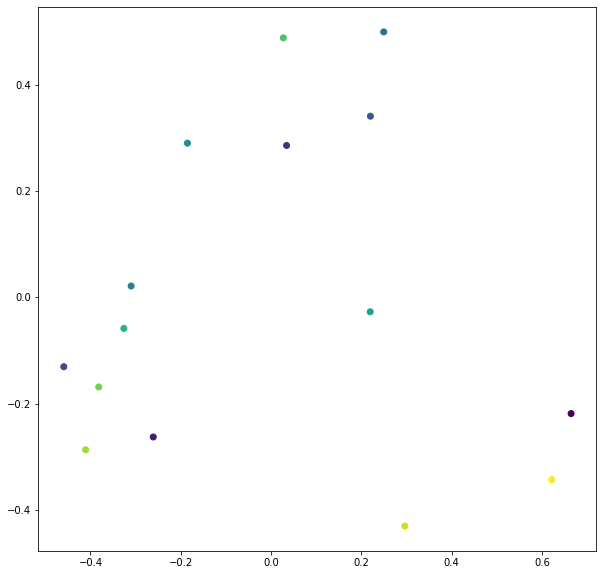

In [162]:
# Kmeans initialization 
km = KMeans(n_clusters=15)
km_pred = km.fit_predict(tf_idf)
# visualization
plt.figure(figsize=(10,10))
plt.scatter(pca_pred[:,0], pca_pred[:,1], c=km_pred)

In [169]:
# точность
accuracy(km_pred)

1.0


## 2) Birch

Birch является очень эффективным алгоритмом кластеризации, так как строит древовидную структуру данных, в которой центроиды кластера считываются с листа. Это могут быть либо окончательные центроиды кластера, либо они могут быть предоставлены в качестве входных данных для другого алгоритма кластеризации

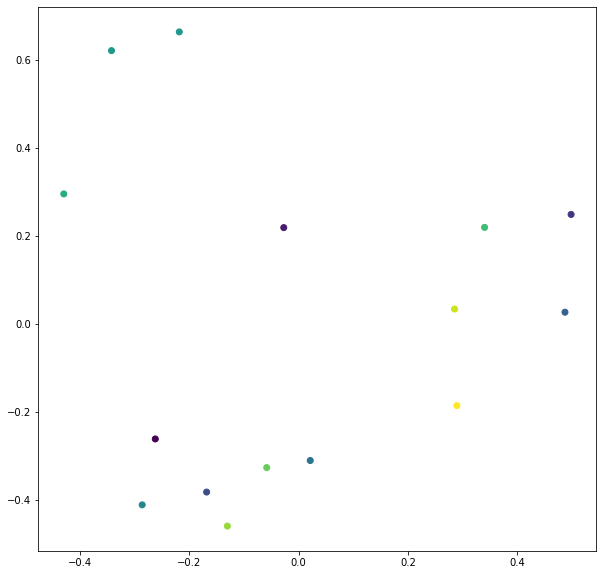

In [164]:
# Birch initialization 
brc = Birch(n_clusters = 15)
brc_pred = brc.fit_predict(tf_idf)
# visualization
plt.figure(figsize=(10,10))
plt.scatter(pca_pred[:,1], pca_pred[:,0], c=brc_pred)

In [165]:
# точность
accuracy(brc_pred)

0.9333333333333333


## 3) AgglomerativeClustering

AgglomerativeClustering выполняет иерархическую кластеризацию по принципу «снизу вверх»: каждое наблюдение начинается в своем собственном кластере, и кластеры последовательно объединяются

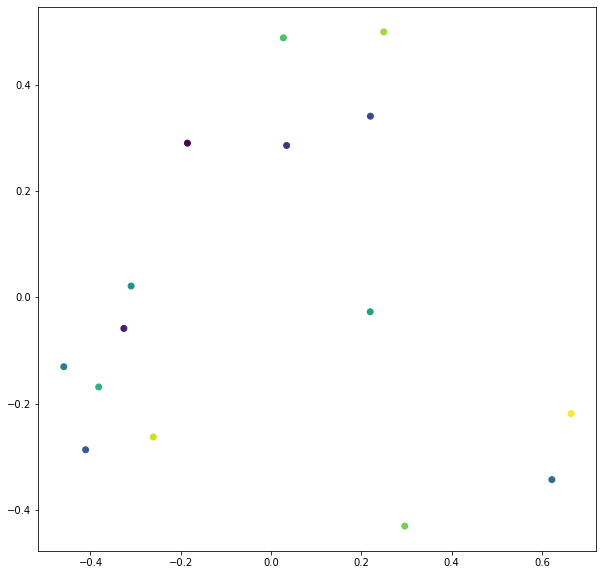

In [167]:
# initialization
ac = AgglomerativeClustering(n_clusters = 15)
ac_pred = ac.fit_predict(tf_idf)
#visualization
plt.figure(figsize=(10,10))
plt.scatter(pca_pred[:,0], pca_pred[:,1], c=ac_pred)

In [168]:
# точность
accuracy(ac_pred)

1.0


Как мы видим, наиболе точными алгоритмами оказались `Kmeans` и `AgglomerativeClustering`. Их показатели равны 1.0, что и доказывает их точность

## Подбор гиперпараметров для оптимизации кластеризации

Подберем гиперпараметры для тематического моделирования LDA с помощью `GridSearchCV`

In [27]:
#импорт
from sklearn.model_selection import GridSearchCV

In [30]:
#векторизация
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(n_df['petition_text'])

In [31]:
# параметры LDA
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# инициализация 
lda = LatentDirichletAllocation()

# GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# поиск гиперпараметров
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [32]:
# лучшиая модель
best_lda_model = model.best_estimator_

# лучшие параметры
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -854218.6841910152
Model Perplexity:  1103.8162671929288


## Вывод:
На этапе кластеризации мы выполнили следующее:
- выполнили кластеризации текстов обращения граждан тремя разными способами
- обосновалми наш выбор алгоритмо для кластеризации
- показали точность работы алгоритмов
- провизуализировали выполненную кластеризацию 
- подобрали гиперпараметры для кластеризации
- выяснили, что алгоритмы Kmeans и AgglomerativeClustering справились максимально точно

---

# Итог:
В ходе выполнения данной сессии мы проделали следующую работу:
- провизуализировали зависимости данных от целевой переменной несколькими способами
- провели векторизацию текстов обращения граждан используя разные методы
- выполнили тематическое моделирование несколькими способами и провизуализировали полученные результаты
- выполнили кластеризацию данных, выбрав несколько алгоритмов, провизуализировали из работу и оценили их точность работы